# Wstęp
Przygotowane zadanie ma na celu sprawdzenie umiejętności kandydatów aplikujących do
na stanowisko Data Science w dziedzinie budowania modeli Machine Learning. Zadanie to
ma przede wszystkim pokazać pewną świadomość działań podejmowanych przez
kandydata w procesie analizy danych i budowania modelu statystycznego.

# Opis zadania
W pliku „house.csv” znajdują się dane dotyczące cen nieruchomości o danych cechach.
Należy wykonać analizę danych prowadzącą do skonstruowania najlepszego modelu, który
na podstawie cech danej nieruchomości dokona predykcji jej ceny, zarówno ciągłej (price)
jak i binarnej (price_bin). Preferowanym językiem do rozwiązania tego zadania jest Python.
Można korzystać z dowolnych bibliotek do analizy danych statystycznych i ML. Rozwiązanie
problemu powinno być przedstawione w postaci analizy dojścia do najlepszego modelu, z
opisami poszczególnych kroków.

# Dane
W pliku „house.csv” znajdują się nieruchomości z ich atrybutami. Analizę modelu należy
wykonać korzystając z następujących danych:

* 'id':str - ID wpisu w bazie,
* 'date':str - data wpisu,
* 'price':float - cena
* 'price_bin':int - binarna zmienna, gdzie ‘1‘ występuje wtedy, kiedy cena jest wyższa od 1mln
* 'bedrooms':float - ilość sypialni,
* 'bathrooms':float - ilość łazienek,
* 'sqft_living':float - powierzchnia użytkowa,
* 'sqft_lot':int - powierzchnia działki,
* 'floors':float - ilość pięter,
* 'waterfront':int - położenie na nabrzeżu {0,1},
* 'view':int - widok (0:4),
* 'condition':int - stan nieruchomości (1:5),
* 'grade':int - nachylenie działki (1:13),
* 'sqft_above':int - powierzchnia poddasza,
* 'sqft_basement':int – powierzchnia piwnicy,
* 'yr_built':int - rok budowy

 'id',
 'date',
 'price',
 'price_bin',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15'

# Sposób prezentacji wyników
Wyniki powinny zostać przesłane w postaci wykonywalnego kodu Python (lub R) z
komentarzami wykonywanych czynności (np. w jupiter notebook, markdown itp.). Dodatkowo
należy dodać krótki opis zrozumienia i analizy danego problemu. Także warto wzbogacić
raport o przemyślenia na temat potencjalnego rozwoju danego rozwiązania lub zupełnie
innych podejść (wystarczy na koniec umieścić w komentarzach).
Wyniki należy wysłać na adres: contact@addepto.com ze stopką [ZADANIE DATA
SCIENCE] . Z kandydatami, którzy prześlą najlepsze rozwiązania będziemy się kontaktować
w celu przeprowadzania dyskusji nad opracowaną analizą.
W razie jakichkolwiek pytań lub problemów z danymi prosimy o kontakt mailowy na powyżej
podany adres.

# Table of contents: <a class="anchor" id="contents"></a>
* [Import libraries, classes and functions](#import-libraries)
* [Configuration](#configuration)
* [Load, Split & Save data](#load-split-save)
* [Analysis and exploration](#analysis-and-exploration)
* [Preprocessing & feature generation](#preprocessing)
* [Regression Models](#regression-models)
    * [Baseline](#baseline)
    * [Linear Regression](#linear-regression)
    * [Elastic Net](#elastic-net)
    * [Decision Tree](#decision-tree)
    * [Random Forest](#random-forest)
    * [Gradient Boosting](#gradient-boosting)
* [Classification Models](#classification-models)

# Import libraries, classes and functions <a class="anchor" id="import-libraries"></a>
[back to table of contents](#contents)

Wczytuję wszystkie używane biblioteki użyte w rozwiązaniu

In [288]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from matplotlib.ticker import FuncFormatter

from scipy.interpolate import griddata

from sklearn.preprocessing import MinMaxScaler

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame


from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier

from sklearn import linear_model
from sklearn import svm
from sklearn import tree
from sklearn import ensemble

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import f1_score
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [71]:
import sklearn.metrics

## support classes

dodatkowe klasy wykorzystane w kodzie poniżej

In [2]:
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
    

class ChangeType(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.astype(self.dtype)

    
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        
        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

In [73]:
y_val

,log_price_per_sqft
622,5.107697
6512,5.919894
3447,5.249652
16010,5.192957
14550,6.538100
7298,5.355140
90,4.812020
13320,5.496234
5186,5.528150
16837,6.035497


In [3]:
class BasicTransformer(BaseEstimator):
    
    def __init__(self, cat_threshold=None, num_strategy='median', return_df=False):
        # store parameters as public attributes
        self.cat_threshold = cat_threshold
        
        if num_strategy not in ['mean', 'median']:
            raise ValueError('num_strategy must be either "mean" or "median"')
        self.num_strategy = num_strategy
        self.return_df = return_df
        
    def fit(self, X, y=None):
        # Assumes X is a DataFrame
        self._columns = X.columns.values
        
        # Split data into categorical and numeric
        self._dtypes = X.dtypes.values
        self._kinds = np.array([dt.kind for dt in X.dtypes])
        self._column_dtypes = {}
        is_cat = self._kinds == 'O'
        self._column_dtypes['cat'] = self._columns[is_cat]
        self._column_dtypes['num'] = self._columns[~is_cat]
        self._feature_names = self._column_dtypes['num']
        
        # Create a dictionary mapping categorical column to unique 
        # values above threshold
        self._cat_cols = {}
        for col in self._column_dtypes['cat']:
            vc = X[col].value_counts()
            if self.cat_threshold is not None:
                vc = vc[vc > self.cat_threshold]
            vals = vc.index.values
            self._cat_cols[col] = vals
            self._feature_names = np.append(self._feature_names, col + '_' + vals)
            
        # get total number of new categorical columns    
        self._total_cat_cols = sum([len(v) for col, v in self._cat_cols.items()])
        
        # get mean or median
        num_cols = self._column_dtypes['num']
        self._num_fill = X[num_cols].agg(self.num_strategy)
        return self
        
    def transform(self, X):
        # check that we have a DataFrame with same column names as 
        # the one we fit
        if set(self._columns) != set(X.columns):
            raise ValueError('Passed DataFrame has different columns than fit DataFrame')
        elif len(self._columns) != len(X.columns):
            raise ValueError('Passed DataFrame has different number of columns than fit DataFrame')
            
        # fill missing values
        num_cols = self._column_dtypes['num']
        X_num = X[num_cols].fillna(self._num_fill)
        
        # Standardize numerics
        std = X_num.std()
        X_num = (X_num - X_num.mean()) / std
        zero_std = np.where(std == 0)[0]
        
        # If there is 0 standard deviation, then all values are the 
        # same. Set them to 0.
        if len(zero_std) > 0:
            X_num.iloc[:, zero_std] = 0
        X_num = X_num.values
        
        # create separate array for new encoded categoricals
        X_cat = np.empty((len(X), self._total_cat_cols), dtype='int')
        i = 0
        for col in self._column_dtypes['cat']:
            vals = self._cat_cols[col]
            for val in vals:
                X_cat[:, i] = X[col] == val
                i += 1
                
        # concatenate transformed numeric and categorical arrays
        data = np.column_stack((X_num, X_cat))
        
        # return either a DataFrame or an array
        if self.return_df:
            return pd.DataFrame(data=data, columns=self._feature_names)
        else:
            return data
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
    
    def get_feature_names():
        return self._feature_names

In [4]:
def save_model_to_joblib(model_name, filename, catalog):
    date = dt.datetime.now().strftime("%Y%m%d_%H%M_")
    filename = date + filename
    joblib_file_path = os.path.join(catalog, filename + '.sav')    
    
    # Save the model as a pickle in a file 
    joblib.dump(model_name, joblib_file_path)
#     print('Model: ', model_name,'\nhas been saved in:\n', joblib_file_path, sep='')
    print('\nModel has been saved in:\n', joblib_file_path, sep='')

In [5]:
def save_predict(df, model_name, target, filename, catalog='models'):
    X_test = df.drop(target, axis=1)
    y_hat = model_name.predict(X_test)
    df[target] = y_hat
    
    save_df_to_pickle(df, filename, catalog)
    print('Prediction saved.')

In [6]:
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
# from sklearn.metrics import classification_report
# , roc_curve

In [7]:
def get_model_results(model_name, model, X, y_true):
    results = pd.DataFrame(columns=['precision_score', 'recall_score', 'f1_score', 'roc_auc_score'])
    y_pred = model.predict(X)
    results = {model_name: {'precision_score': precision_score(y_true, y_pred),
                            'recall_score': recall_score(y_true, y_pred),
                            'f1_score': f1_score(y_true, y_pred),
                            'roc_auc_score': roc_auc_score(y_true, y_pred),
                            'accuracy_score': accuracy_score(y_true, y_pred)
                           }
              }
    
    return pd.DataFrame.from_dict(results, orient='index')

# Configuration <a class="anchor" id="configuration"></a>
[back to table of contents](#contents)

Definiuję zmienne wskazujące ścieżki dostępu do folderów w repozytorium

In [8]:
pd.set_option('display.max_columns', 0)
pd.set_option('display.max_rows', 1000)

# file paths
raw_data_path = os.path.join(os.path.pardir,'data','raw')
house_data_path = os.path.join(raw_data_path, 'house.csv')

processed_data_path = os.path.join(os.path.pardir,'data','processed')
interim_data_path = os.path.join(os.path.pardir,'data','interim') 
external_data_path = os.path.join(os.path.pardir,'data','external')

reports_path = os.path.join(os.path.pardir, 'reports')
figures_path = os.path.join(reports_path, 'figures')

models_path = os.path.join(os.path.pardir, 'models')

#config_path = os.path.join(os.path.pardir,'c.env')

# Load, Split & Save data <a class="anchor" id="load-split-save"></a>
[back to table of contents](#contents)

Wczytuję dane źródłowe, dzielę na zbiór treningowy, walidacyjny oraz testowy. Zapisuję w postaci później użwyanego pickle.

## Load

In [20]:
dateColumns = ['date']

In [21]:
df_raw = pd.read_csv(house_data_path, low_memory=False, parse_dates=dateColumns, infer_datetime_format=True)

In [22]:
df_raw.shape

(21613, 22)

### check Nulls

In [23]:
df_raw.isnull().sum()

id               0
date             0
price            0
price_bin        0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### check column's dtypes

In [24]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 22 columns):
id               21613 non-null int64
date             21613 non-null datetime64[ns]
price            21613 non-null float64
price_bin        21613 non-null int64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: datetime64[ns](1), float64(5

### use only columns from task description + positional

In [25]:
valid_cols = [
    'id',
    'date',
    'price',
    'price_bin',
    'bedrooms',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
    'waterfront',
    'view',
    'condition',
    'grade',
    'sqft_above',
    'sqft_basement',
    'yr_built',
    'lat',
    'long'
]

target = ['price', 'price_bin']
positional = ['lat', 'long']

In [26]:
X = df_raw[list(set(valid_cols) - set(target))].copy()
y = df_raw['price'].copy()

In [27]:
X.head().T

,0,1,2,3,4
id,7129300520,6414100192,5631500400,2487200875,1954400510
sqft_basement,0,400,0,910,0
view,0,0,0,0,0
sqft_above,1180,2170,770,1050,1680
grade,7,7,6,7,8
sqft_living,1180,2570,770,1960,1680
waterfront,0,0,0,0,0
floors,1,2,1,1,1
date,2014-10-13 00:00:00,2014-12-09 00:00:00,2015-02-25 00:00:00,2014-12-09 00:00:00,2015-02-18 00:00:00
lat,47.5112,47.721,47.7379,47.5208,47.6168


## Split to test, validation, train

In [28]:
X.shape, y.shape

((21613, 16), (21613,))

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.40, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((12967, 16), (12967,), (8646, 16), (8646,))

In [30]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.25, random_state=42)
X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6484, 16), (6484,), (2162, 16), (2162,))

## Save

### save df

In [31]:
def save_df_to_pickle(df, filename, catalog):
    date = dt.datetime.now().strftime("%Y%m%d_%H%M_")
    filename = date + filename
    pickle_file_path = os.path.join(catalog, filename + '.pkl')
    df.to_pickle(pickle_file_path)
    print('Pickle saved in: ', pickle_file_path)

In [32]:
catalog = processed_data_path 

In [33]:
filename = 'X_train'
save_df_to_pickle(X_train, filename, catalog)
filename = 'y_train'
save_df_to_pickle(y_train, filename, catalog)

Pickle saved in:  ..\data\processed\20200201_1851_X_train.pkl
Pickle saved in:  ..\data\processed\20200201_1851_y_train.pkl


In [38]:
filename = 'X_val'
save_df_to_pickle(X_val, filename, catalog)
filename = 'y_val'
save_df_to_pickle(y_val, filename, catalog)

Pickle saved in:  ..\data\processed\20200201_1852_X_val.pkl
Pickle saved in:  ..\data\processed\20200201_1852_y_val.pkl


In [39]:
filename = 'X_test'
save_df_to_pickle(X_test, filename, catalog)
filename = 'y_test'
save_df_to_pickle(y_test, filename, catalog)

Pickle saved in:  ..\data\processed\20200201_1852_X_test.pkl
Pickle saved in:  ..\data\processed\20200201_1852_y_test.pkl


## Check loading

In [40]:
catalog = processed_data_path
filename = '20200201_1852_X_test.pkl'
pickle_file_path = os.path.join(catalog, filename)

df_loaded = pd.read_pickle(pickle_file_path)
df_loaded.shape

(2162, 16)

In [41]:
df_loaded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2162 entries, 5133 to 5723
Data columns (total 16 columns):
id               2162 non-null int64
sqft_basement    2162 non-null int64
view             2162 non-null int64
sqft_above       2162 non-null int64
grade            2162 non-null int64
sqft_living      2162 non-null int64
waterfront       2162 non-null int64
floors           2162 non-null float64
date             2162 non-null datetime64[ns]
lat              2162 non-null float64
yr_built         2162 non-null int64
bathrooms        2162 non-null float64
bedrooms         2162 non-null int64
sqft_lot         2162 non-null int64
condition        2162 non-null int64
long             2162 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(11)
memory usage: 287.1 KB


# =====&&&&&&&&&&&&&&&&&&&&&&&&&&======

### load all

Wczytuję wcześniej zapisane pickle

In [176]:
catalog = processed_data_path

filename = '20200201_1851_X_train.pkl'
pickle_file_path = os.path.join(catalog, filename)
X_train = pd.read_pickle(pickle_file_path)
filename = '20200201_1851_y_train.pkl'
pickle_file_path = os.path.join(catalog, filename)
y_train = pd.read_pickle(pickle_file_path)

filename = '20200201_1852_X_val.pkl'
pickle_file_path = os.path.join(catalog, filename)
X_val = pd.read_pickle(pickle_file_path)
filename = '20200201_1852_y_val.pkl'
pickle_file_path = os.path.join(catalog, filename)
y_val = pd.read_pickle(pickle_file_path)

filename = '20200201_1852_X_test.pkl'
pickle_file_path = os.path.join(catalog, filename)
X_test = pd.read_pickle(pickle_file_path)
filename = '20200201_1852_y_test.pkl'
pickle_file_path = os.path.join(catalog, filename)
y_test = pd.read_pickle(pickle_file_path)

In [177]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((12967, 16), (12967,), (6484, 16), (6484,), (2162, 16), (2162,))

# Analysis and exploration <a class="anchor" id="analysis-and-exploration"></a>
[back to table of contents](#contents)

Wykonuję analizę danych treningowych

In [178]:
df = pd.concat([X_train, y_train], axis=1)

In [179]:
pd.DataFrame((df['sqft_above'] + df['sqft_basement'])/df['sqft_living']).mean()

0    1.0
dtype: float64

In [180]:
df['price_per_sqft'] = df['price']/df['sqft_living']

In [181]:
cols_to_plot = [
    'bathrooms',
    'yr_built',
    'sqft_above',
    'floors',
    'bedrooms',
    'sqft_living',
    'grade',
    'condition',
    'sqft_lot',
    'view',
    'sqft_basement',
    'waterfront',
    'price',
    'price_per_sqft'
]

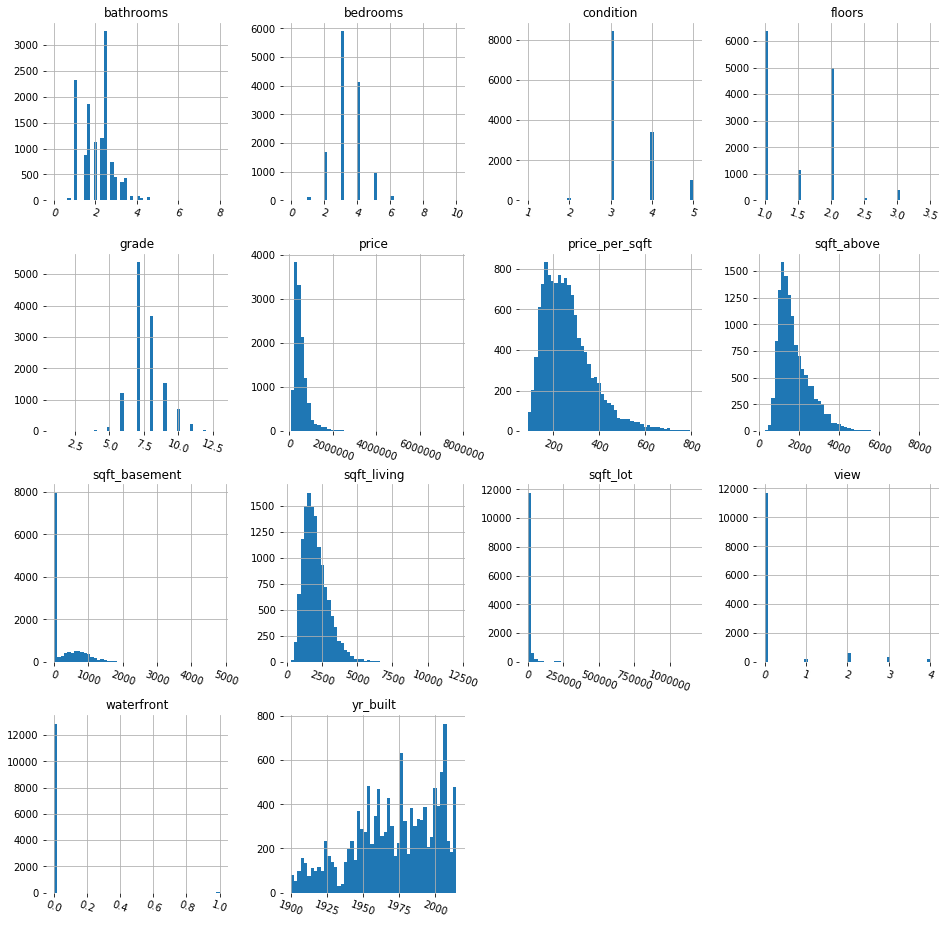

In [182]:
h = df[cols_to_plot].hist(bins=50, figsize=(16,16), xlabelsize='10', ylabelsize='10', xrot=-20)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

## Analysis summary

Zmienna celu 'price' jest wyraźnie skośna. By zmniejszyć ten efekt w trakcie modelowania funkcji regresji zastosuję funkcję transformującą (logarytm) oraz później jego odwrotność (exp).

Wcześniejsza analiza graficzna na wybranym zakresie czasowym danych nie wykazała wyraźnego trendu w cenach.

# PreProcessing & feature generation <a class="anchor" id="preprocessing"></a>
[back to table of contents](#contents)

## function definition

In [247]:
catalog = processed_data_path

filename = '20200201_1851_X_train.pkl'
pickle_file_path = os.path.join(catalog, filename)
X_train = pd.read_pickle(pickle_file_path)
filename = '20200201_1851_y_train.pkl'
pickle_file_path = os.path.join(catalog, filename)
y_train = pd.read_pickle(pickle_file_path)

filename = '20200201_1852_X_val.pkl'
pickle_file_path = os.path.join(catalog, filename)
X_val = pd.read_pickle(pickle_file_path)
filename = '20200201_1852_y_val.pkl'
pickle_file_path = os.path.join(catalog, filename)
y_val = pd.read_pickle(pickle_file_path)

filename = '20200201_1852_X_test.pkl'
pickle_file_path = os.path.join(catalog, filename)
X_test = pd.read_pickle(pickle_file_path)
filename = '20200201_1852_y_test.pkl'
pickle_file_path = os.path.join(catalog, filename)
y_test = pd.read_pickle(pickle_file_path)

In [248]:
def feature_generation(df):
#     df['log_sqft_above'] = np.log(df['sqft_above'])
    df['log_sqft_living'] = np.log(df['sqft_living'])
#     df['log_sqft_basement'] = np.log(df['sqft_basement'])
    
    df['price_per_sqft'] = df['price']/df['sqft_living']
    df['log_price_per_sqft'] = np.log(df['price_per_sqft'])

    df['bath_per_bed'] = df['bathrooms']/(df['bedrooms']+0.1)
    df['has_basement'] = [int(el > 0) for el in df['sqft_basement']]
    df['surface_above_perc'] = df['sqft_above']/df['sqft_living']
    
    df['log_sqft_lot'] = np.log(df['sqft_lot'])
    df['lot_is_bigger'] = (df['sqft_lot'] > df['sqft_living']).apply(int)
    df['surface_lot_perc'] = df['sqft_lot']/df['sqft_living']
    
    
    df['built_before_34'] = [int(el < 1934) for el in df['yr_built']]
    df['built_before_WWII'] = [int(el < 1942) for el in df['yr_built']]
    df['house_age'] = 2015 - df['yr_built']
    
    df['transaction_year'] = df['date'].dt.year
    df['transaction_month'] = df['date'].dt.month

In [249]:
def define_X_and_y(df):
    predictors = [
#         'sqft_above',
#         'sqft_living',
#         'sqft_basement',
        
#         'log_sqft_above',
        'log_sqft_living',
#         'log_sqft_basement',
    
        'bathrooms',
        'bedrooms',
        'bath_per_bed',
        'floors',
        'has_basement',
        'surface_above_perc',

        #'sqft_lot',
        'log_sqft_lot',
        'surface_lot_perc',
        'lot_is_bigger',

        'grade',
        'condition',
        'view',
        'waterfront',

        'built_before_34',
        'built_before_WWII',
        'house_age',

        'transaction_year',
        'transaction_month'
    ]
#     target = ['log_price_per_sqft']
#     target = ['price_per_sqft']
    target = ['price']
    X = df[predictors].copy()
    y = df[target].copy()
    return X, y

In [250]:
def main(df):
    df_tmp = df.copy()
    feature_generation(df_tmp)
    X, y = define_X_and_y(df_tmp)
    print(X.shape, y.shape)
    #print(X.info())
    return X, y

## X and y creation

In [251]:
df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [252]:
df_train.shape, df_val.shape, df_test.shape

((12967, 17), (6484, 17), (2162, 17))

In [253]:
X_train, y_train = main(df_train)
X_val, y_val = main(df_val)
X_test, y_test = main(df_test)

(12967, 19) (12967, 1)
(6484, 19) (6484, 1)
(2162, 19) (2162, 1)


In [254]:
df_train.shape, df_val.shape, df_test.shape

((12967, 17), (6484, 17), (2162, 17))

# Regression Models <a class="anchor" id="regression-models"></a>
[back to table of contents](#contents)

Wybrałem metrykę R2 dla wyznaczania regresji 

## baseline <a class="anchor" id="baseline"></a>
[back to table of contents](#contents)

In [255]:
dummy_mean_model = DummyRegressor(strategy='mean')
dummy_median_model = DummyRegressor(strategy='median')
dummy_const_model = DummyRegressor(strategy='constant', constant=10000)

In [256]:
dummy_mean_model.fit(X_train, y_train)
dummy_mean_model.score(X_val, y_val)

-0.00045173660930308834

In [257]:
dummy_median_model.fit(X_train, y_train)
dummy_median_model.score(X_val, y_val)

-0.061211379880942385

### set of columns definition 

In [258]:
bins_cols = [
    'bathrooms',
    'bedrooms',
    'surface_above_perc',
    'surface_lot_perc',
    'house_age',
]

In [259]:
onehot_cols = [
    'has_basement',
    'lot_is_bigger',
    'waterfront',
    'built_before_34',
    'built_before_WWII'
]

In [260]:
all_cols = list(X_train.columns)

## Linear Regression <a class="anchor" id="linear-regression"></a>
[back to table of contents](#contents)

In [285]:
def train_and_save_model(catalog, filename, 
                         all_cols, bins_cols, onehot_cols,
                         do_bins=False, do_onehot=False,
                         n_bins=5,
                         drop=None, handle_unknown='ignore', 
                         ttrans=False, save=False):
    
    all_selector = ColumnSelector(columns=all_cols)
    
    bins_selector = ColumnSelector(columns=bins_cols)
    bins_creator = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    bins_pipe = ("bins_pipe", make_pipeline(bins_selector,
                                            bins_creator))
    
    onehot_selector = ColumnSelector(columns=onehot_cols)
    onehot_creator = OneHotEncoder(categories='auto', drop=drop, sparse=True, handle_unknown=handle_unknown)
    onehot_pipe = ("onehot_pipe", make_pipeline(onehot_selector,
                                                onehot_creator))

    if do_bins and do_onehot:
        rest_cols = list(set(all_cols)-set(bins_cols)-set(onehot_cols))
    elif do_bins:
        rest_cols = list(set(all_cols)-set(bins_cols))
    elif do_onehot:
        rest_cols = list(set(all_cols)-set(onehot_cols))
    else:
        print('no bins and no onehot')
        rest_cols = all_cols
    rest_selector = ColumnSelector(columns=rest_cols)
    rest_pipe = ("rest_pipe", make_pipeline(rest_selector))
    
    if do_bins and do_onehot:
        feature_union = FeatureUnion(transformer_list=[bins_pipe,
                                                       onehot_pipe,
                                                      rest_pipe])
    elif do_bins:
        feature_union = FeatureUnion(transformer_list=[bins_pipe,
                                                      rest_pipe])
    elif do_onehot:
        feature_union = FeatureUnion(transformer_list=[onehot_pipe,
                                                      rest_pipe])
    else:
        feature_union = all_selector

    preprocess_pipeline = feature_union

    lr = linear_model.LinearRegression()

    if ttrans:
        transtarget = TransformedTargetRegressor(regressor=lr, func=np.log, inverse_func=np.exp)
        model_pipeline = Pipeline([('preprocess', preprocess_pipeline),
                                   ('model_transtarget', transtarget)])
    else:    
        model_pipeline = Pipeline([('preprocess', preprocess_pipeline),
                                   ('model_lr', lr)])

    model_pipeline.fit(X_train, y_train)
    
    if save:
        save_model_to_joblib(model_pipeline, filename, catalog)
    print('\nScore on Training dataset:', model_pipeline.score(X_train, y_train))
    print('\nScore on Validation dataset:', model_pipeline.score(X_val, y_val))
    
    return model_pipeline

In [289]:
catalog = models_path
filename = 'model_reg'
model_reg = train_and_save_model(catalog, filename,
                                 all_cols, bins_cols, onehot_cols,
                                 do_bins=True, do_onehot=True,
                                 n_bins=5,
                                 drop=None, handle_unknown='ignore', 
                                 ttrans=True, save=True)


Model has been saved in:
..\models\20200203_0102_model_reg.sav

Score on Training dataset: 0.6960680902908383

Score on Validation dataset: 0.6838771385263851


## Elastic Net <a class="anchor" id="elastic-net"></a>
[back to table of contents](#contents)

In [271]:
n_bins=5
drop=None
handle_unknown='ignore' 
ttrans=True

alpha = 0.02
l1_ratio = 0.9
max_iter = 2000

grid_all_selector = ColumnSelector(columns=all_cols)

grid_bins_selector = ColumnSelector(columns=bins_cols)
grid_bins_creator = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
grid_bins_pipe = ("bins_pipe", make_pipeline(grid_bins_selector,
                                             grid_bins_creator))

grid_onehot_selector = ColumnSelector(columns=onehot_cols)
grid_onehot_creator = OneHotEncoder(categories='auto', drop=drop, sparse=True, handle_unknown=handle_unknown)
grid_onehot_pipe = ("onehot_pipe", make_pipeline(grid_onehot_selector,
                                                 grid_onehot_creator))

grid_rest_cols = list(set(all_cols)-set(bins_cols)-set(onehot_cols))
grid_rest_selector = ColumnSelector(columns=grid_rest_cols)
grid_rest_pipe = ("rest_pipe", make_pipeline(grid_rest_selector))

grid_feature_union = FeatureUnion(transformer_list=[grid_bins_pipe,
                                                    grid_onehot_pipe,
                                                    grid_rest_pipe])
grid_preprocess_pipeline = grid_feature_union

grid_enet = linear_model.ElasticNet(alpha=alpha, 
                                    l1_ratio=l1_ratio, 
                                    max_iter=max_iter, 
                                    random_state=42)

grid_transtarget_enet = TransformedTargetRegressor(regressor=grid_enet, func=np.log, inverse_func=np.exp)
grid_pipeline_enet = Pipeline([('preprocess', grid_preprocess_pipeline),
                               ('model_transtarget_enet', grid_transtarget_enet)])

grid_pipeline_enet.fit(X_train, y_train)

print('\nScore on Training dataset:', grid_pipeline_enet.score(X_train, y_train))
print('\nScore on Validation dataset:', grid_pipeline_enet.score(X_val, y_val))


Score on Training dataset: 0.6336614222834775

Score on Validation dataset: 0.6141724260415454


In [272]:
list(grid_pipeline_enet.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocess',
 'model_transtarget_enet',
 'preprocess__n_jobs',
 'preprocess__transformer_list',
 'preprocess__transformer_weights',
 'preprocess__verbose',
 'preprocess__bins_pipe',
 'preprocess__onehot_pipe',
 'preprocess__rest_pipe',
 'preprocess__bins_pipe__memory',
 'preprocess__bins_pipe__steps',
 'preprocess__bins_pipe__verbose',
 'preprocess__bins_pipe__columnselector',
 'preprocess__bins_pipe__kbinsdiscretizer',
 'preprocess__bins_pipe__columnselector__columns',
 'preprocess__bins_pipe__kbinsdiscretizer__encode',
 'preprocess__bins_pipe__kbinsdiscretizer__n_bins',
 'preprocess__bins_pipe__kbinsdiscretizer__strategy',
 'preprocess__onehot_pipe__memory',
 'preprocess__onehot_pipe__steps',
 'preprocess__onehot_pipe__verbose',
 'preprocess__onehot_pipe__columnselector',
 'preprocess__onehot_pipe__onehotencoder',
 'preprocess__onehot_pipe__columnselector__columns',
 'preprocess__onehot_pipe__onehotencoder__categorical_features',
 'preprocess__oneho

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

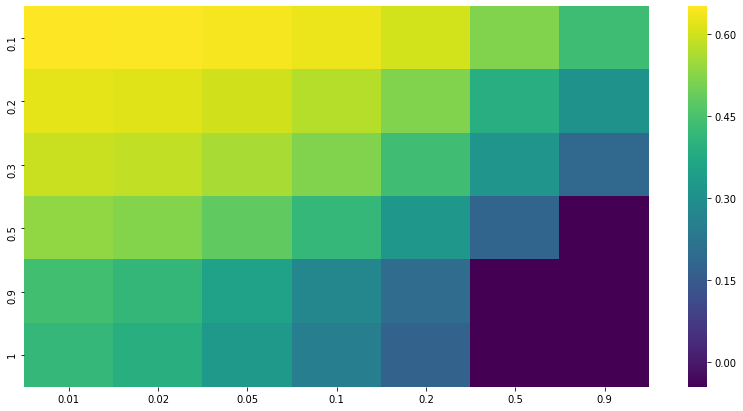

In [280]:
alpha = [0.1, 0.2, 0.3, 0.5, 0.9, 1]
l1_ratio = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.9]

max_iter = [2000]

param_grid = dict(model_transtarget_enet__regressor__alpha=alpha,
                  model_transtarget_enet__regressor__l1_ratio=l1_ratio,
                  model_transtarget_enet__regressor__max_iter=max_iter                  
                  )

grid_search = GridSearchCV(grid_pipeline_enet, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

plt.figure(figsize = (14,7))
sns.heatmap(grid_search.cv_results_['mean_test_score'].reshape(6,7),
           yticklabels=param_grid['model_transtarget_enet__regressor__alpha'],
           xticklabels=param_grid['model_transtarget_enet__regressor__l1_ratio'],
           cmap='viridis')

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    5.8s finished


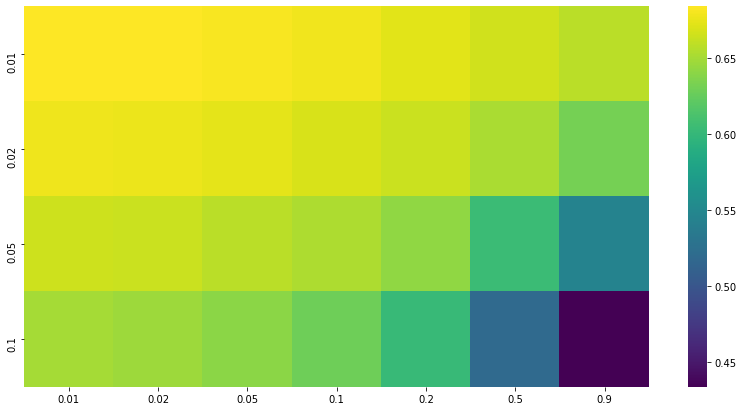

In [281]:
alpha = [0.01, 0.02, 0.05, 0.1]
l1_ratio = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.9]

max_iter = [2000]

param_grid = dict(model_transtarget_enet__regressor__alpha=alpha,
                  model_transtarget_enet__regressor__l1_ratio=l1_ratio,
                  model_transtarget_enet__regressor__max_iter=max_iter                  
                  )

grid_search = GridSearchCV(grid_pipeline_enet, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

plt.figure(figsize = (14,7))
sns.heatmap(grid_search.cv_results_['mean_test_score'].reshape(4,7),
           yticklabels=param_grid['model_transtarget_enet__regressor__alpha'],
           xticklabels=param_grid['model_transtarget_enet__regressor__l1_ratio'],
           cmap='viridis')

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    6.9s finished


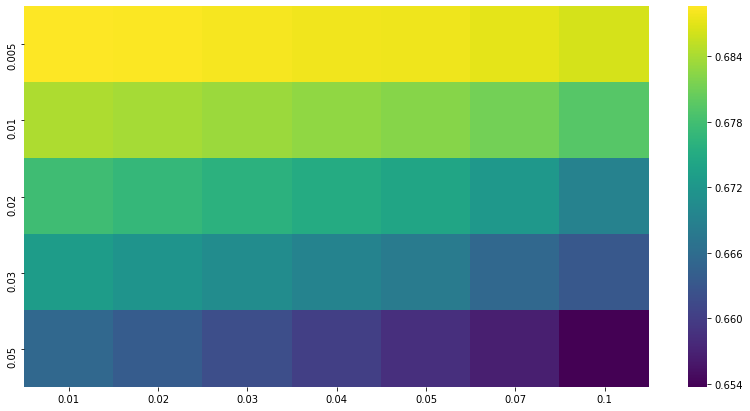

In [277]:
alpha = [0.005, 0.01, 0.02, 0.03, 0.05]
l1_ratio = [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.1]

max_iter = [2000]

param_grid = dict(model_transtarget_enet__regressor__alpha=alpha,
                  model_transtarget_enet__regressor__l1_ratio=l1_ratio,
                  model_transtarget_enet__regressor__max_iter=max_iter                  
                  )

grid_search = GridSearchCV(grid_pipeline_enet, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

plt.figure(figsize = (14,7))
sns.heatmap(grid_search.cv_results_['mean_test_score'].reshape(5,7),
           yticklabels=param_grid['model_transtarget_enet__regressor__alpha'],
           xticklabels=param_grid['model_transtarget_enet__regressor__l1_ratio'],
           cmap='viridis')

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:   15.5s finished


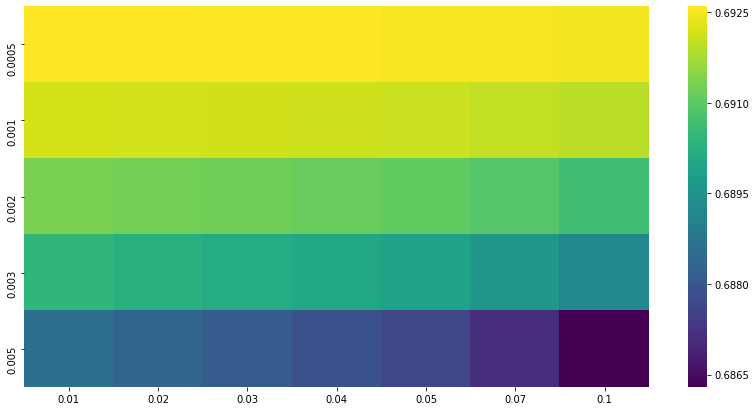

In [278]:
alpha = [0.0005, 0.001, 0.002, 0.003, 0.005]
l1_ratio = [0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.1]

max_iter = [2000]

param_grid = dict(model_transtarget_enet__regressor__alpha=alpha,
                  model_transtarget_enet__regressor__l1_ratio=l1_ratio,
                  model_transtarget_enet__regressor__max_iter=max_iter                  
                  )

grid_search = GridSearchCV(grid_pipeline_enet, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

plt.figure(figsize = (14,7))
sns.heatmap(grid_search.cv_results_['mean_test_score'].reshape(5,7),
           yticklabels=param_grid['model_transtarget_enet__regressor__alpha'],
           xticklabels=param_grid['model_transtarget_enet__regressor__l1_ratio'],
           cmap='viridis')

In [292]:
catalog = models_path
filename = 'model_enet'
save_model_to_joblib(grid_search.best_estimator_, filename, catalog)
print('\nScore on Training dataset:', grid_search.best_estimator_.score(X_train, y_train))
print('\nScore on Validation dataset:', grid_search.best_estimator_.score(X_val, y_val))


Model has been saved in:
..\models\20200203_0106_model_enet.sav

Score on Training dataset: 0.6956775057536465

Score on Validation dataset: 0.6832009710291


## Decision Tree <a class="anchor" id="decision-tree"></a>
[back to table of contents](#contents)

In [296]:
def train_and_save_model_tree(catalog, filename,
                              all_cols, bins_cols, onehot_cols,
                              do_bins=False, do_onehot=False,
                              n_bins=5,
                              drop=None, handle_unknown='ignore', 
                              ttrans=False, save=False,
                              max_depth=None, min_samples_split=2, min_samples_leaf=1,
                              min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None):
    
    dtree = tree.DecisionTreeRegressor(criterion='mse',
                                     splitter='best',
                                     max_depth=max_depth,
                                     min_samples_split=min_samples_split,
                                     min_samples_leaf=min_samples_leaf,
                                     min_weight_fraction_leaf=min_weight_fraction_leaf,
                                     max_features=max_features,
                                     random_state=42,
                                     max_leaf_nodes=max_leaf_nodes,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     presort=False)
    
    all_selector = ColumnSelector(columns=all_cols)
    
    bins_selector = ColumnSelector(columns=bins_cols)
    bins_creator = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    bins_pipe = ("bins_pipe", make_pipeline(bins_selector,
                                            bins_creator))
    
    onehot_selector = ColumnSelector(columns=onehot_cols)
    onehot_creator = OneHotEncoder(categories='auto', drop=drop, sparse=True, handle_unknown=handle_unknown)
    onehot_pipe = ("onehot_pipe", make_pipeline(onehot_selector,
                                                onehot_creator))

    if do_bins and do_onehot:
        rest_cols = list(set(all_cols)-set(bins_cols)-set(onehot_cols))
    elif do_bins:
        rest_cols = list(set(all_cols)-set(bins_cols))
    elif do_onehot:
        rest_cols = list(set(all_cols)-set(onehot_cols))
    else:
        print('no bins and no onehot')
        rest_cols = all_cols
    rest_selector = ColumnSelector(columns=rest_cols)
    rest_pipe = ("rest_pipe", make_pipeline(rest_selector))
    
    if do_bins and do_onehot:
        feature_union = FeatureUnion(transformer_list=[bins_pipe,
                                                       onehot_pipe,
                                                      rest_pipe])
    elif do_bins:
        feature_union = FeatureUnion(transformer_list=[bins_pipe,
                                                      rest_pipe])
    elif do_onehot:
        feature_union = FeatureUnion(transformer_list=[onehot_pipe,
                                                      rest_pipe])
    else:
        feature_union = all_selector

    preprocess_pipeline = feature_union

    if ttrans:
        transtarget = TransformedTargetRegressor(regressor=dtree, func=np.log, inverse_func=np.exp)
        model_pipeline = Pipeline([('preprocess', preprocess_pipeline),
                                   ('model_transtarget_dtree', transtarget)])
    else:    
        model_pipeline = Pipeline([('preprocess', preprocess_pipeline),
                                   ('model_dtree', dtree)])

    model_pipeline.fit(X_train, y_train)
    
    if save:
        save_model_to_joblib(model_pipeline, filename, catalog)
    print('\nScore on Training dataset:', model_pipeline.score(X_train, y_train))
    print('\nScore on Validation dataset:', model_pipeline.score(X_val, y_val))
    
    return model_pipeline


In [305]:
catalog = models_path
filename = 'model_dtree'
model_reg = train_and_save_model_tree(catalog, filename,
                                      all_cols, bins_cols, onehot_cols,
                                      do_bins=False, do_onehot=False,
                                      n_bins=5,
                                      drop=None, handle_unknown='ignore', 
                                      ttrans=False, save=False,
                                      max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                      min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None)

no bins and no onehot

Score on Training dataset: 0.9999995049649351

Score on Validation dataset: 0.4581652153492519


Dla modelu drzewa decyzyjnego przy ustawieniach domyślnych model przeucza się. Można to stwierdzić po tym, że scoring na zbiorze treningowym jest bardzo wysoki, natomiast wynik jest niski dla zbioru walidacyjnego. 

### grid search for Decision Tree

In [306]:
criterion='mse'
splitter='best'
max_depth=None
min_samples_split=2
min_samples_leaf=1
min_weight_fraction_leaf=0.0
max_features=None
max_leaf_nodes=None


grid_dtree = tree.DecisionTreeRegressor(criterion='mse',
                                 splitter='best',
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 min_weight_fraction_leaf=min_weight_fraction_leaf,
                                 max_features=max_features,
                                 random_state=42,
                                 max_leaf_nodes=max_leaf_nodes,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 presort=False)

grid_all_selector = ColumnSelector(columns=all_cols)

preprocess_pipeline = grid_all_selector

grid_model_pipeline_dtree = Pipeline([('preprocess', grid_preprocess_pipeline),
                               ('model_dtree', grid_dtree)])

grid_model_pipeline_dtree.fit(X_train, y_train)

print('\nScore on Training dataset:', grid_model_pipeline_dtree.score(X_train, y_train))
print('\nScore on Validation dataset:', grid_model_pipeline_dtree.score(X_val, y_val))


Score on Training dataset: 0.9999994105808176

Score on Validation dataset: 0.4766058672813348


In [307]:
list(grid_model_pipeline_dtree.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocess',
 'model_dtree',
 'preprocess__n_jobs',
 'preprocess__transformer_list',
 'preprocess__transformer_weights',
 'preprocess__verbose',
 'preprocess__bins_pipe',
 'preprocess__onehot_pipe',
 'preprocess__rest_pipe',
 'preprocess__bins_pipe__memory',
 'preprocess__bins_pipe__steps',
 'preprocess__bins_pipe__verbose',
 'preprocess__bins_pipe__columnselector',
 'preprocess__bins_pipe__kbinsdiscretizer',
 'preprocess__bins_pipe__columnselector__columns',
 'preprocess__bins_pipe__kbinsdiscretizer__encode',
 'preprocess__bins_pipe__kbinsdiscretizer__n_bins',
 'preprocess__bins_pipe__kbinsdiscretizer__strategy',
 'preprocess__onehot_pipe__memory',
 'preprocess__onehot_pipe__steps',
 'preprocess__onehot_pipe__verbose',
 'preprocess__onehot_pipe__columnselector',
 'preprocess__onehot_pipe__onehotencoder',
 'preprocess__onehot_pipe__columnselector__columns',
 'preprocess__onehot_pipe__onehotencoder__categorical_features',
 'preprocess__onehot_pipe__one

#### search for optimal max_depth and num_samples_split

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1406s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0531s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    9.0s finished


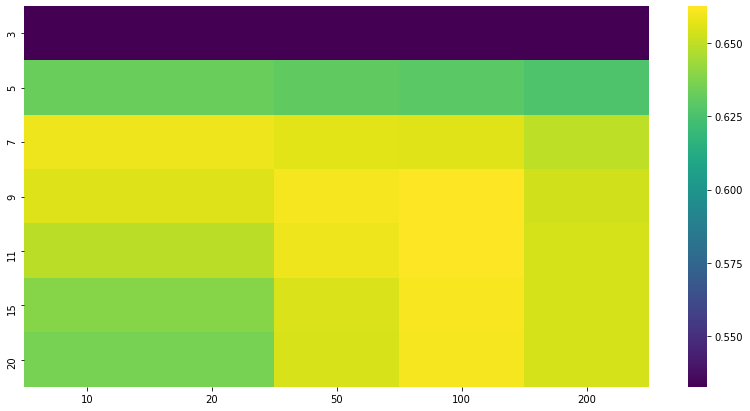

In [311]:
depths = [3,5,7,9,11,15,20]
samples_split = [10, 20, 50, 100, 200]

min_leaf = [10]

m_features=['auto']

param_grid = dict(model_dtree__max_depth=depths,
                  model_dtree__min_samples_split=samples_split,
                  model_dtree__min_samples_leaf=min_leaf,
                  model_dtree__max_features=m_features
                  )

grid_search = GridSearchCV(grid_model_pipeline_dtree, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

plt.figure(figsize = (14,7))
sns.heatmap(grid_search.cv_results_['mean_test_score'].reshape(7,5),
           yticklabels=param_grid['model_dtree__max_depth'],
           xticklabels=param_grid['model_dtree__min_samples_split'],
           cmap='viridis')

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    5.8s finished


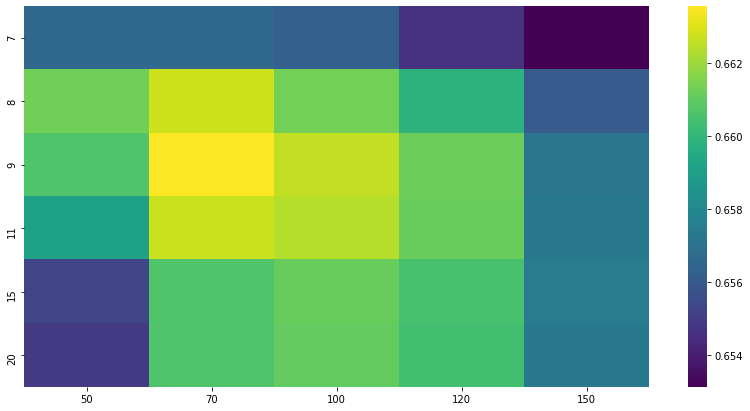

In [314]:
depths = [7,8,9,11,15,20]
samples_split = [50, 70, 100, 120, 150]

min_leaf = [10]

m_features=['auto']

param_grid = dict(model_dtree__max_depth=depths,
                  model_dtree__min_samples_split=samples_split,
                  model_dtree__min_samples_leaf=min_leaf,
                  model_dtree__max_features=m_features
                  )

grid_search = GridSearchCV(grid_model_pipeline_dtree, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

plt.figure(figsize = (14,7))
sns.heatmap(grid_search.cv_results_['mean_test_score'].reshape(6,5),
           yticklabels=param_grid['model_dtree__max_depth'],
           xticklabels=param_grid['model_dtree__min_samples_split'],
           cmap='viridis')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:    1.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.5s finished


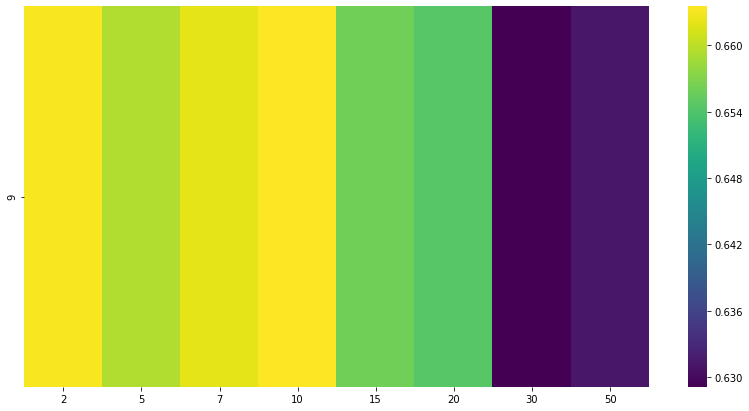

In [324]:
depths = [9]
samples_split = [70]

min_leaf = [2,5,7,10,15,20,30,50]

m_features=['auto']

param_grid = dict(model_dtree__max_depth=depths,
                  model_dtree__min_samples_split=samples_split,
                  model_dtree__min_samples_leaf=min_leaf,
                  model_dtree__max_features=m_features
                  )

grid_search = GridSearchCV(grid_model_pipeline_dtree, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

plt.figure(figsize = (14,7))
sns.heatmap(grid_search.cv_results_['mean_test_score'].reshape(1,8),
           yticklabels=param_grid['model_dtree__max_depth'],
           xticklabels=param_grid['model_dtree__min_samples_leaf'],
           cmap='viridis')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1718s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  40 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  20 out of  40 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.2s finished


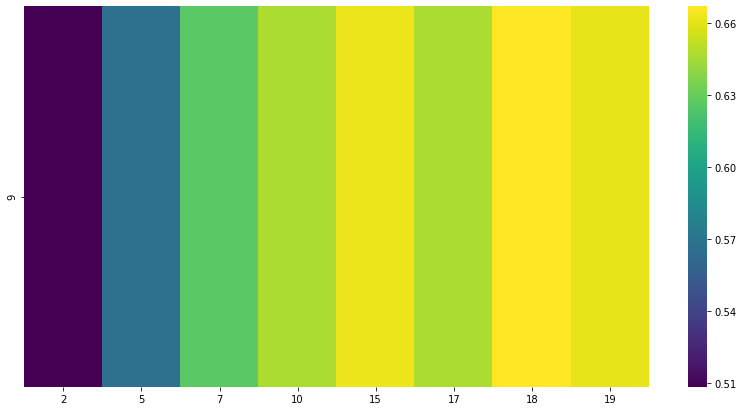

In [326]:
depths = [9]
samples_split = [70]

min_leaf = [10]

m_features = [2,5,7,10,15,17,18,19]

param_grid = dict(model_dtree__max_depth=depths,
                  model_dtree__min_samples_split=samples_split,
                  model_dtree__min_samples_leaf=min_leaf,
                  model_dtree__max_features=m_features
                  )

grid_search = GridSearchCV(grid_model_pipeline_dtree, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

plt.figure(figsize = (14,7))
sns.heatmap(grid_search.cv_results_['mean_test_score'].reshape(1,8),
           yticklabels=param_grid['model_dtree__max_depth'],
           xticklabels=param_grid['model_dtree__max_features'],
           cmap='viridis')

In [330]:
catalog = models_path
filename = 'model_dtree'
save_model_to_joblib(grid_search.best_estimator_, filename, catalog)
print('\nScore on Training dataset:', grid_search.best_estimator_.score(X_train, y_train))
print('\nScore on Validation dataset:', grid_search.best_estimator_.score(X_val, y_val))


Model has been saved in:
..\models\20200203_2218_model_dtree.sav

Score on Training dataset: 0.716895626771932

Score on Validation dataset: 0.6449436368056641


## Random Forest <a class="anchor" id="random-forest"></a>
[back to table of contents](#contents)

In [331]:
def train_and_save_model_rforest(catalog, filename,
                              all_cols, bins_cols, onehot_cols,
                              do_bins=False, do_onehot=False,
                              n_bins=5,
                              drop=None, handle_unknown='ignore', 
                              ttrans=False, save=False,
                              n_estimators=100, max_depth=None, min_samples_split=2,
                              min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                              max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
                              bootstrap=True, oob_score=False, n_jobs=None, random_state=42, verbose=0,
                              warm_start=False):
    
    rforest = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                             criterion='mse',
                                             max_depth=max_depth,
                                             min_samples_split=min_samples_split,
                                             min_samples_leaf=min_samples_leaf,
                                             min_weight_fraction_leaf=0.0,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             bootstrap=True,
                                             oob_score=False,
                                             n_jobs=None,
                                             random_state=random_state,
                                             verbose=0,
                                             warm_start=False
                                             )
    
    all_selector = ColumnSelector(columns=all_cols)
    
    bins_selector = ColumnSelector(columns=bins_cols)
    bins_creator = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    bins_pipe = ("bins_pipe", make_pipeline(bins_selector,
                                            bins_creator))
    
    onehot_selector = ColumnSelector(columns=onehot_cols)
    onehot_creator = OneHotEncoder(categories='auto', drop=drop, sparse=True, handle_unknown=handle_unknown)
    onehot_pipe = ("onehot_pipe", make_pipeline(onehot_selector,
                                                onehot_creator))

    if do_bins and do_onehot:
        rest_cols = list(set(all_cols)-set(bins_cols)-set(onehot_cols))
    elif do_bins:
        rest_cols = list(set(all_cols)-set(bins_cols))
    elif do_onehot:
        rest_cols = list(set(all_cols)-set(onehot_cols))
    else:
        print('no bins and no onehot')
        rest_cols = all_cols
    rest_selector = ColumnSelector(columns=rest_cols)
    rest_pipe = ("rest_pipe", make_pipeline(rest_selector))
    
    if do_bins and do_onehot:
        feature_union = FeatureUnion(transformer_list=[bins_pipe,
                                                       onehot_pipe,
                                                      rest_pipe])
    elif do_bins:
        feature_union = FeatureUnion(transformer_list=[bins_pipe,
                                                      rest_pipe])
    elif do_onehot:
        feature_union = FeatureUnion(transformer_list=[onehot_pipe,
                                                      rest_pipe])
    else:
        feature_union = all_selector

    preprocess_pipeline = feature_union

    if ttrans:
        transtarget = TransformedTargetRegressor(regressor=rforest, func=np.log, inverse_func=np.exp)
        model_pipeline = Pipeline([('preprocess', preprocess_pipeline),
                                   ('model_transtarget_rforest', transtarget)])
    else:    
        model_pipeline = Pipeline([('preprocess', preprocess_pipeline),
                                   ('model_rforest', rforest)])

    model_pipeline.fit(X_train, y_train.values.ravel())
    
    if save:
        save_model_to_joblib(model_pipeline, filename, catalog)
    print('\nScore on Training dataset:', model_pipeline.score(X_train, y_train))
    print('\nScore on Validation dataset:', model_pipeline.score(X_val, y_val))
    
    return model_pipeline

In [332]:
catalog = models_path
filename = 'model_rforest'
model_reg = train_and_save_model_rforest(catalog, filename,
                                         all_cols, bins_cols, onehot_cols,
                                         do_bins=False, do_onehot=False,
                                         n_bins=5,
                                         drop=None, handle_unknown='ignore', 
                                         ttrans=False, save=False,
                                         n_estimators=100, max_depth=None, min_samples_split=2,
                                         min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                                         max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
                                         bootstrap=True, oob_score=False, n_jobs=None, random_state=42, verbose=0,
                                         warm_start=False)

no bins and no onehot


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



Score on Training dataset: 0.9604624710820232

Score on Validation dataset: 0.7068651215749213


### grid search for Random Forest

In [343]:
n_estimators=100
max_depth=None 
min_samples_split=2
min_samples_leaf=1
max_features='auto'
    
grid_rforest = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                             criterion='mse',
                                             max_depth=max_depth,
                                             min_samples_split=min_samples_split,
                                             min_samples_leaf=min_samples_leaf,
                                             min_weight_fraction_leaf=0.0,
                                             max_features=max_features,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             bootstrap=True,
                                             oob_score=False,
                                             n_jobs=-1,
                                             random_state=42,
                                             verbose=0,
                                             warm_start=False
                                             )

grid_all_selector = ColumnSelector(columns=all_cols)

preprocess_pipeline = grid_all_selector

grid_model_pipeline_rforest = Pipeline([('preprocess', grid_preprocess_pipeline),
                               ('model_rforest', grid_rforest)])

grid_model_pipeline_rforest.fit(X_train, y_train.values.ravel())

print('\nScore on Training dataset:', grid_model_pipeline_rforest.score(X_train, y_train))
print('\nScore on Validation dataset:', grid_model_pipeline_rforest.score(X_val, y_val))


Score on Training dataset: 0.9592840028850634

Score on Validation dataset: 0.7071515022089659


In [340]:
list(grid_model_pipeline_rforest.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocess',
 'model_rforest',
 'preprocess__n_jobs',
 'preprocess__transformer_list',
 'preprocess__transformer_weights',
 'preprocess__verbose',
 'preprocess__bins_pipe',
 'preprocess__onehot_pipe',
 'preprocess__rest_pipe',
 'preprocess__bins_pipe__memory',
 'preprocess__bins_pipe__steps',
 'preprocess__bins_pipe__verbose',
 'preprocess__bins_pipe__columnselector',
 'preprocess__bins_pipe__kbinsdiscretizer',
 'preprocess__bins_pipe__columnselector__columns',
 'preprocess__bins_pipe__kbinsdiscretizer__encode',
 'preprocess__bins_pipe__kbinsdiscretizer__n_bins',
 'preprocess__bins_pipe__kbinsdiscretizer__strategy',
 'preprocess__onehot_pipe__memory',
 'preprocess__onehot_pipe__steps',
 'preprocess__onehot_pipe__verbose',
 'preprocess__onehot_pipe__columnselector',
 'preprocess__onehot_pipe__onehotencoder',
 'preprocess__onehot_pipe__columnselector__columns',
 'preprocess__onehot_pipe__onehotencoder__categorical_features',
 'preprocess__onehot_pipe__o

#### n_estimators

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    5.4s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:    6.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   13.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.9s finished


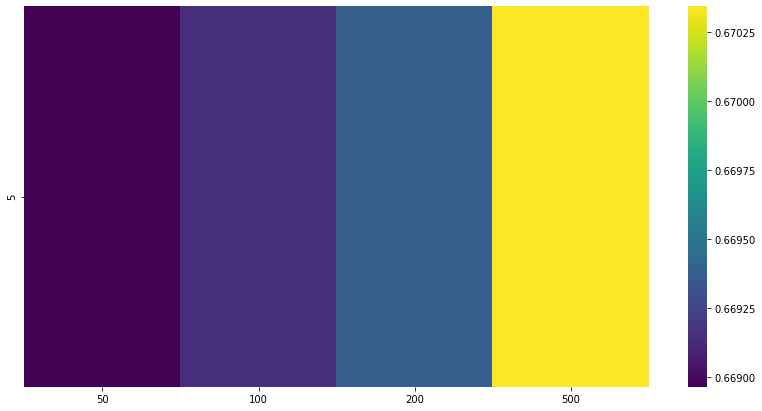

In [353]:
n_est = [50, 100, 200, 500]
depths = [5]
samples_split = [20]

min_leaf = [10]

m_features = [10]# [4,5,7,10,15,17,18,19]

param_grid = dict(model_rforest__n_estimators=n_est,
                  model_rforest__max_depth=depths,
                  model_rforest__min_samples_split=samples_split,
                  model_rforest__min_samples_leaf=min_leaf,
                  model_rforest__max_features=m_features
                  )

grid_search = GridSearchCV(grid_model_pipeline_rforest, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

plt.figure(figsize = (14,7))
sns.heatmap(grid_search.cv_results_['mean_test_score'].reshape(1,4),
           yticklabels=param_grid['model_rforest__max_depth'],
           xticklabels=param_grid['model_rforest__n_estimators'],
           cmap='viridis')

#### max_depth and num_samples_split

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   18.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.2s finished


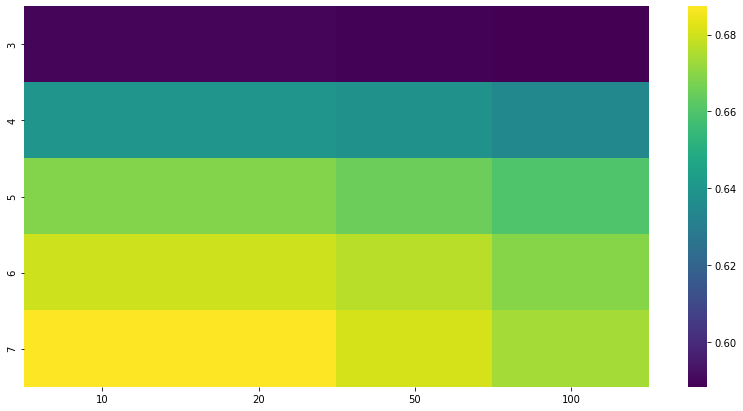

In [354]:
n_est = [50]
depths = [3,4,5,6,7]
samples_split = [10,20,50,100]

min_leaf = [10]

m_features = [10]# [4,5,7,10,15,17,18,19]

param_grid = dict(model_rforest__n_estimators=n_est,
                  model_rforest__max_depth=depths,
                  model_rforest__min_samples_split=samples_split,
                  model_rforest__min_samples_leaf=min_leaf,
                  model_rforest__max_features=m_features
                  )

grid_search = GridSearchCV(grid_model_pipeline_rforest, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

plt.figure(figsize = (14,7))
sns.heatmap(grid_search.cv_results_['mean_test_score'].reshape(5,4),
           yticklabels=param_grid['model_rforest__max_depth'],
           xticklabels=param_grid['model_rforest__min_samples_split'],
           cmap='viridis')

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   23.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   24.4s finished


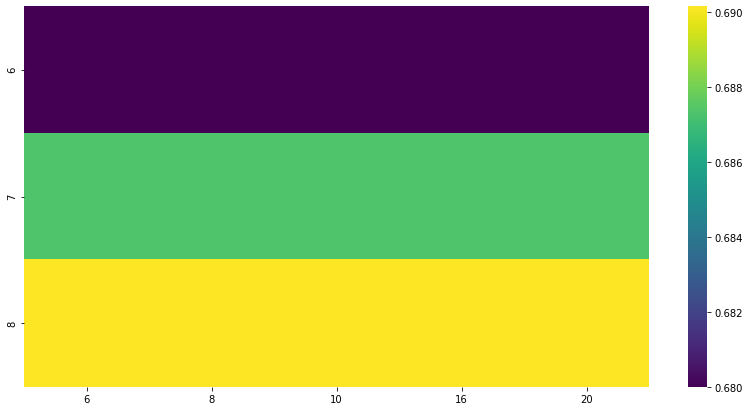

In [355]:
n_est = [50]
depths = [6,7,8]
samples_split = [6,8,10,16,20]

min_leaf = [10]

m_features = [10]# [4,5,7,10,15,17,18,19]

param_grid = dict(model_rforest__n_estimators=n_est,
                  model_rforest__max_depth=depths,
                  model_rforest__min_samples_split=samples_split,
                  model_rforest__min_samples_leaf=min_leaf,
                  model_rforest__max_features=m_features
                  )

grid_search = GridSearchCV(grid_model_pipeline_rforest, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

plt.figure(figsize = (14,7))
sns.heatmap(grid_search.cv_results_['mean_test_score'].reshape(3,5),
           yticklabels=param_grid['model_rforest__max_depth'],
           xticklabels=param_grid['model_rforest__min_samples_split'],
           cmap='viridis')

#### min_samples_leaf

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    3.0s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:    3.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:    3.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.8s finished


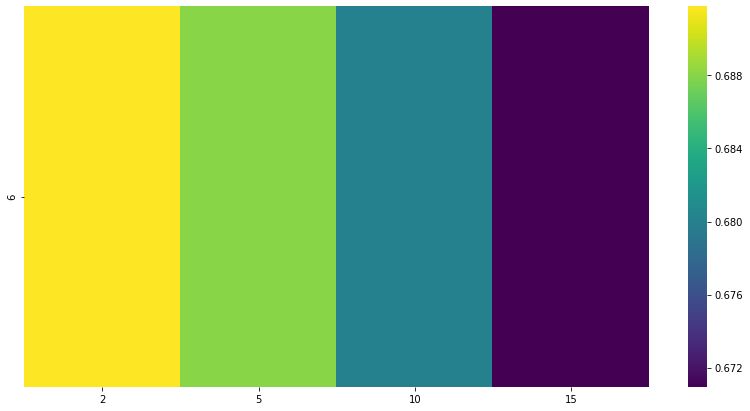

In [357]:
n_est = [50]
depths = [6]
samples_split = [10]

min_leaf = [2,5,10,15]

m_features = [10]# [4,5,7,10,15,17,18,19]

param_grid = dict(model_rforest__n_estimators=n_est,
                  model_rforest__max_depth=depths,
                  model_rforest__min_samples_split=samples_split,
                  model_rforest__min_samples_leaf=min_leaf,
                  model_rforest__max_features=m_features
                  )

grid_search = GridSearchCV(grid_model_pipeline_rforest, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

plt.figure(figsize = (14,7))
sns.heatmap(grid_search.cv_results_['mean_test_score'].reshape(1,4),
           yticklabels=param_grid['model_rforest__max_depth'],
           xticklabels=param_grid['model_rforest__min_samples_leaf'],
           cmap='viridis')

#### max_features

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    4.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    4.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    6.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.2s finished


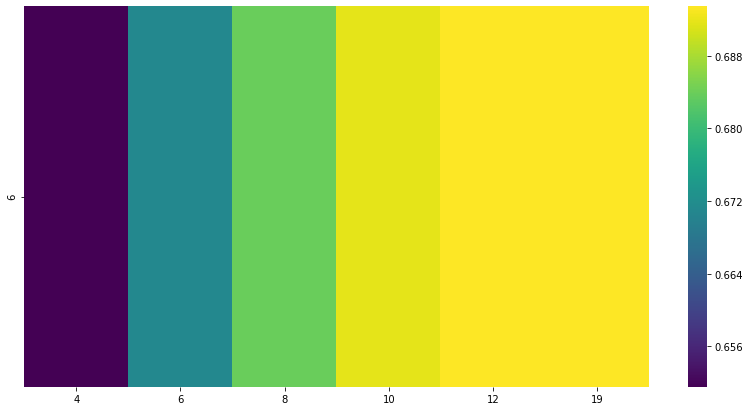

In [358]:
n_est = [50]
depths = [6]
samples_split = [10]

min_leaf = [2]

m_features = [4,6,8,10,12,19]# [4,5,7,10,15,17,18,19]

param_grid = dict(model_rforest__n_estimators=n_est,
                  model_rforest__max_depth=depths,
                  model_rforest__min_samples_split=samples_split,
                  model_rforest__min_samples_leaf=min_leaf,
                  model_rforest__max_features=m_features
                  )

grid_search = GridSearchCV(grid_model_pipeline_rforest, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

plt.figure(figsize = (14,7))
sns.heatmap(grid_search.cv_results_['mean_test_score'].reshape(1,6),
           yticklabels=param_grid['model_rforest__max_depth'],
           xticklabels=param_grid['model_rforest__max_features'],
           cmap='viridis')

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    3.6s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    4.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    5.9s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    6.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.5s finished


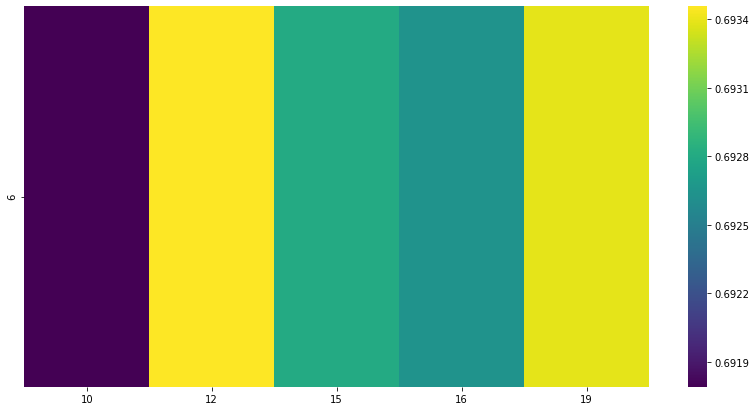

In [359]:
n_est = [50]
depths = [6]
samples_split = [10]

min_leaf = [2]

m_features = [10,12,15,16,19]# [4,5,7,10,15,17,18,19]

param_grid = dict(model_rforest__n_estimators=n_est,
                  model_rforest__max_depth=depths,
                  model_rforest__min_samples_split=samples_split,
                  model_rforest__min_samples_leaf=min_leaf,
                  model_rforest__max_features=m_features
                  )

grid_search = GridSearchCV(grid_model_pipeline_rforest, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

plt.figure(figsize = (14,7))
sns.heatmap(grid_search.cv_results_['mean_test_score'].reshape(1,5),
           yticklabels=param_grid['model_rforest__max_depth'],
           xticklabels=param_grid['model_rforest__max_features'],
           cmap='viridis')

#### n_estimator

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    8.1s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   16.7s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   29.8s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   44.5s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   49.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   49.4s finished


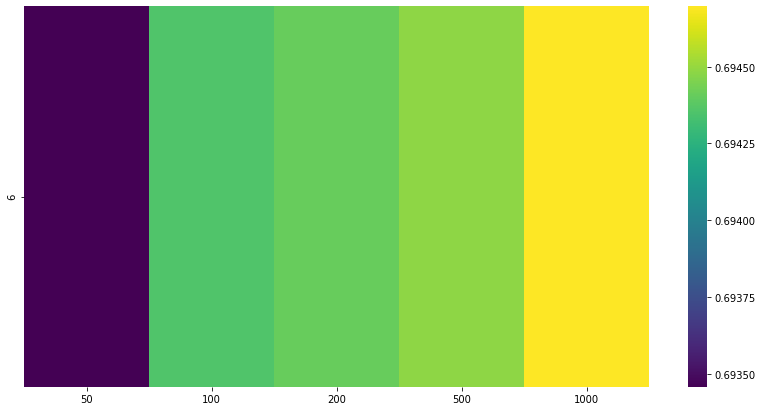

In [360]:
n_est = [50,100,200,500,1000]
depths = [6]
samples_split = [10]

min_leaf = [2]

m_features = [12]# [4,5,7,10,15,17,18,19]

param_grid = dict(model_rforest__n_estimators=n_est,
                  model_rforest__max_depth=depths,
                  model_rforest__min_samples_split=samples_split,
                  model_rforest__min_samples_leaf=min_leaf,
                  model_rforest__max_features=m_features
                  )

grid_search = GridSearchCV(grid_model_pipeline_rforest, param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train.values.ravel())

plt.figure(figsize = (14,7))
sns.heatmap(grid_search.cv_results_['mean_test_score'].reshape(1,5),
           yticklabels=param_grid['model_rforest__max_depth'],
           xticklabels=param_grid['model_rforest__n_estimators'],
           cmap='viridis')

In [361]:
catalog = models_path
filename = 'model_rforest'
save_model_to_joblib(grid_search.best_estimator_, filename, catalog)
print('\nScore on Training dataset:', grid_search.best_estimator_.score(X_train, y_train))
print('\nScore on Validation dataset:', grid_search.best_estimator_.score(X_val, y_val))


Model has been saved in:
..\models\20200203_2307_model_rforest.sav

Score on Training dataset: 0.7331455372703068

Score on Validation dataset: 0.6959858764829823


## Gradient Boosting <a class="anchor" id="gradient-boosting"></a>
[back to table of contents](#contents)

TBC

# Classification Models <a class="anchor" id="classification-models"></a>
[back to table of contents](#contents)

## baseline

In [362]:
dummy_most_frequent_model = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_stratified_model = DummyClassifier(strategy='stratified', random_state=42)
dummy_uniform_model = DummyClassifier(strategy='uniform', random_state=42)
dummy_constant_1_model = DummyClassifier(strategy='constant', constant=1)
dummy_constant_0_model = DummyClassifier(strategy='constant', constant=0)

In [363]:
dummy_most_frequent_model.fit(X_train, y_train)
print(dummy_most_frequent_model.score(X_val, y_val))
print(f1_score(y_val, dummy_most_frequent_model.predict(X_val)))

0.007865515114127083


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [207]:
catalog = models_path
filename = 'model_reg'
model_reg = train_and_save_model(catalog, filename,
                                 all_cols, bins_cols, onehot_cols,
                                 do_bins=True, do_onehot=True,
                                 n_bins=5,
                                 drop=None, handle_unknown='ignore', 
                                 ttrans=False, save=False)

11111
(12967, 24)
(6484, 24)

Score on Validation dataset: 0.5929371726492925


In [154]:
catalog = models_path
filename = 'model_reg'
model_reg = train_and_save_model(catalog, filename,
                                 all_cols, bins_cols, onehot_cols,
                                 do_bins=True, do_onehot=True,
                                 n_bins=4,
                                 drop=None, handle_unknown='ignore', 
                                 ttrans=True, save=False)

11111
(12967, 23)
(6484, 23)

Score on Validation dataset: 0.271465661963899


In [91]:
lin_m.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [92]:
lin_m.score(X_train, y_train)

0.3412931881138648

In [93]:
lin_m.score(X_val, y_val)

0.3447929614278533

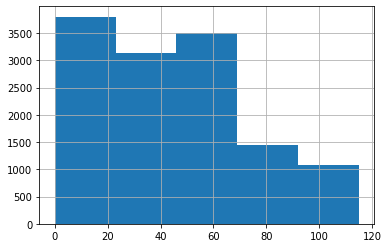

In [173]:
X_train['house_age'].hist(bins=5)

In [174]:
tmp_bins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

In [175]:
pd.DataFrame(tmp_bins.fit_transform(X_train[['house_age']]), columns=['tmp_bins']).tmp_bins.value_counts()

0.0    3799
2.0    3496
1.0    3137
3.0    1453
4.0    1082
Name: tmp_bins, dtype: int64

In [171]:
tmp_bins = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')

In [172]:
pd.DataFrame(tmp_bins.fit_transform(X_train[['bathrooms']]), columns=['tmp_bins']).tmp_bins.value_counts()

3.0    5556
0.0    3237
1.0    2981
2.0    1193
Name: tmp_bins, dtype: int64

In [69]:
catalog = models_path
filename = 'model_reg'
model_reg = train_and_save_model(catalog, filename,
                                 all_cols, bins_cols, onehot_cols,
                                 do_bins=False, do_onehot=False,
                                 n_bins=5,
                                 drop=None, handle_unknown='ignore', 
                                 ttrans=True, save=False)

44444
(12967, 18)
(6484, 18)

Score on Validation dataset: 0.3312530535995152


In [70]:
model_reg.predict(X_val)

array([[5.49165406],
       [6.01073378],
       [5.29970616],
       ...,
       [5.4019585 ],
       [5.37807452],
       [5.63674132]])

In [92]:
catalog = models_path
filename = 'model_reg'
model_reg = train_and_save_model(catalog, filename,
                                 all_cols, bins_cols, onehot_cols,
                                 do_bins=False, do_onehot=False,
                                 n_bins=5,
                                 drop=None, handle_unknown='ignore', 
                                 ttrans=True, save=False)

44444
(12967, 18)
(6484, 18)

Score on Validation dataset: 0.29171055059498596


In [49]:
X_train.head().T

,2679,18912,18208,17819,9459
id,6791400800,2425049066,2579500110,2420069268,721049096
sqft_basement,280,1000,1690,0,0
view,0,3,3,0,0
sqft_above,1550,2070,1840,1230,4850
grade,7,9,9,6,10
sqft_living,1830,3070,3530,1230,4850
waterfront,0,0,1,0,0
floors,1,1,1,1,2
date,2015-04-13 00:00:00,2014-06-16 00:00:00,2014-07-01 00:00:00,2014-08-21 00:00:00,2014-05-27 00:00:00
lat,47.3126,47.64,47.5358,47.2064,47.3181


In [93]:
model_reg.predict(X_val)

array([[246.16274836],
       [406.80181442],
       [201.63763383],
       ...,
       [225.55532565],
       [220.11239278],
       [284.46422874]])

In [94]:
r2_score(y_val, model_reg.predict(X_val))

0.29171055059498596

In [74]:
catalog = models_path
filename = 'model_reg'
model_reg = train_and_save_model(catalog, filename,
                                 all_cols, bins_cols, onehot_cols,
                                 do_bins=False, do_onehot=False,
                                 n_bins=5,
                                 drop=None, handle_unknown='ignore', 
                                 ttrans=False, save=False)

44444
(12967, 18)
(6484, 18)

Score on Validation dataset: 0.33339558350656195


In [75]:
model_reg.predict(X_val)

array([[5.5059929 ],
       [6.00832612],
       [5.30647219],
       ...,
       [5.41856548],
       [5.39413829],
       [5.65060751]])

In [87]:
lin_m = linear_model.LinearRegression()

In [88]:
X_train.describe()

,bathrooms,bedrooms,bath_per_bed,floors,has_basement,surface_above_perc,log_sqft_lot,surface_lot_perc,lot_is_bigger,grade,condition,view,waterfront,built_before_34,built_before_WWII,house_age,transaction_year,transaction_month
count,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000
mean,2.112844,3.362227,1.103351,1.499267,0.390144,0.876071,8.984515,7.371680,0.961826,7.651731,3.410349,0.232513,0.006864,0.130562,0.160253,43.871520,2014.323899,6.578854
std,0.763987,0.899535,32.255571,0.543229,0.487801,0.170795,0.907117,22.149685,0.191623,1.171385,0.650557,0.759635,0.082565,0.336934,0.366855,29.406463,0.467980,3.113478
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.397059,6.253829,0.214876,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,1.000000
25%,1.750000,3.000000,0.499833,1.000000,0.000000,0.726636,8.517193,2.421739,1.000000,7.000000,3.000000,0.000000,0.000000,0.000000,0.000000,18.000000,2014.000000,4.000000
50%,2.250000,3.000000,0.624844,1.500000,0.000000,1.000000,8.931288,4.037657,1.000000,7.000000,3.000000,0.000000,0.000000,0.000000,0.000000,40.000000,2014.000000,6.000000
75%,2.500000,4.000000,0.749813,2.000000,1.000000,1.000000,9.274254,6.413278,1.000000,8.000000,4.000000,0.000000,0.000000,0.000000,0.000000,64.000000,2015.000000,9.000000
max,8.000000,10.000000,2500.000000,3.500000,1.000000,1.000000,13.968055,1640.554930,1.000000,13.000000,5.000000,4.000000,1.000000,1.000000,1.000000,115.000000,2015.000000,12.000000


In [79]:
r2_score(y_val, model_reg.predict(X_val))

0.33339558350656195

In [95]:
catalog = models_path
filename = 'model_reg'
model_reg = train_and_save_model(catalog, filename,
                                 all_cols, bins_cols, onehot_cols,
                                 do_bins=False, do_onehot=False,
                                 n_bins=5,
                                 drop=None, handle_unknown='ignore', 
                                 ttrans=False, save=False)

44444
(12967, 18)
(6484, 18)

Score on Validation dataset: 0.3448958221649695


In [96]:
model_reg.predict(X_val)

array([[267.17241115],
       [409.02130813],
       [208.42420466],
       ...,
       [248.40924909],
       [240.70270043],
       [307.0868653 ]])

In [98]:
r2_score(y_val, model_reg.predict(X_val))

0.3448958221649695

In [67]:
X_train.shape, X_val.shape

((12967, 18), (6484, 18))

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
train_and_save_model()

In [ ]:
def train_and_save_model_dtree_kbin(x_cols, catalog, filename, save=False, num=False, cat=False,
                               max_depth=10, min_samples_split=2, min_samples_leaf=10,
                               min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None):
    
    dtree = tree.DecisionTreeClassifier(criterion='gini',
                                        splitter='best',
                                        max_depth=max_depth,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        min_weight_fraction_leaf=min_weight_fraction_leaf,
                                        max_features=max_features,
                                        random_state=42,
                                        max_leaf_nodes=max_leaf_nodes,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        class_weight=None,
                                        presort=False)
        
    
    column_selector = ColumnSelector(columns=x_cols)

    numeric_imputer = ("numeric_imputer", make_pipeline(TypeSelector("float"),
                                                        SimpleImputer(strategy='median')))
    categorical_imputer = ("categorical_imputer", make_pipeline(TypeSelector('category'),
                                                                SimpleImputer(strategy='constant',
                                                                              fill_value=-999),
                                                                KBinsDiscretizer(n_bins=5, 
                                                                                 encode='ordinal', 
                                                                                 strategy='quantile')
                                                               ))
    object_imputer = ("object_imputer", make_pipeline(TypeSelector("object"),
                                                      SimpleImputer(strategy='constant', 
                                                                    fill_value='no_data')))
      
    if num and cat:
        feature_union = FeatureUnion(transformer_list=[numeric_imputer,
                                                      categorical_imputer,
                                                      # object_imputer
                                                        ])
    elif num:
        feature_union = FeatureUnion(transformer_list=[numeric_imputer,
                                                      # categorical_imputer,
                                                      # object_imputer
                                                        ])
    elif cat:
        feature_union = FeatureUnion(transformer_list=[#numeric_imputer,
                                                      categorical_imputer,
                                                      # object_imputer
                                                        ])
    else:
        return print('At least cat or num should be True')

    preprocess_pipeline = Pipeline([("column_selector", column_selector),
                                    ("feature_union", feature_union)
                                   ])

    model_pipeline = Pipeline([('preprocess', preprocess_pipeline),
                               ('model_dtree', dtree)])

    model_pipeline.fit(X_train, y_train)
    
    print(preprocess_pipeline.fit_transform(X_train).shape)
    print(X_train[x_cols].info())
#     print(preprocess_pipeline.transform(X_val).shape)
#     print(X_val[x_cols].info())
    if save:
        save_model_to_joblib(model_pipeline, filename, catalog)
#     print('\nScore on Validation dataset:', model_pipeline.score(X_val, y_val))
          
    return model_pipeline

In [ ]:
def train_and_save_model(bins_cols, catalog, filename, 
                         ttrans=False, drop=None, handle_unknown='ignore', 
                         save=False, num=False, cat=False):

    column_selector = ColumnSelector(columns=bins_cols)

    
    preprocess_pipeline = Pipeline([("column_selector", column_selector),
                                    ("feature_union", feature_union)
                                   ])    
    
    
    numeric_imputer = ("numeric_imputer", make_pipeline(TypeSelector("float"), 
                                                          SimpleImputer(strategy='median')))
    categorical_imputer = ("categorical_imputer", make_pipeline(TypeSelector('category'),
                                                                ChangeType('str'),
                                                                OneHotEncoder(categories='auto',
                                                                              drop=drop, 
                                                                              sparse=True, 
                                                                              handle_unknown=handle_unknown) # TODO change in prod
#                                                                 SimpleImputer(strategy='constant', fill_value='no_data')))
#                                                                 SimpleImputer(strategy='most_frequent'),
                                                               ))
    object_imputer = ("object_imputer", make_pipeline(TypeSelector("object"),
                                                      SimpleImputer(strategy='constant', fill_value='no_data')))
#                                                         SimpleImputer(strategy='most_frequent')))
      
    if num and cat:
        feature_union = FeatureUnion(transformer_list=[numeric_imputer,
                                                      categorical_imputer,
                                                      # object_imputer
                                                        ])
    elif num:
        feature_union = FeatureUnion(transformer_list=[numeric_imputer,
                                                      # categorical_imputer,
                                                      # object_imputer
                                                        ])
    elif cat:
        feature_union = FeatureUnion(transformer_list=[#numeric_imputer,
                                                      categorical_imputer,
                                                      # object_imputer
                                                        ])
    else:
        return print('At least cat or num should be True')
    
    
    preprocess_pipeline = Pipeline([("column_selector", column_selector),
                                    ("feature_union", feature_union)
                                   ])

    lr = linear_model.LinearRegression()

    if ttrans:
        transtarget = TransformedTargetRegressor(regressor=lr, func=np.log, inverse_func=np.exp)
        model_pipeline = Pipeline([('preprocess', preprocess_pipeline),
                                   ('model_transtarget', transtarget)])
    else:    
        model_pipeline = Pipeline([('preprocess', preprocess_pipeline),
                                   ('model_lr', lr)])

    model_pipeline.fit(X_train, y_train)
    
    print(preprocess_pipeline.fit_transform(X_train).shape)
    print(X_train[x_cols].info())
    print(preprocess_pipeline.transform(X_val).shape)
    print(X_val[x_cols].info())
    if save:
        save_model_to_joblib(model_pipeline, filename, catalog)
    print('\nScore on Validation dataset:', model_pipeline.score(X_val, y_val))
    
    return model_pipeline

In [31]:
list(X_train.columns)

['bathrooms',
 'bedrooms',
 'bath_per_bed',
 'floors',
 'has_basement',
 'surface_above_perc',
 'log_sqft_lot',
 'surface_lot_perc',
 'lot_is_bigger',
 'grade',
 'condition',
 'view',
 'waterfront',
 'built_before_34',
 'built_before_WWII',
 'house_age',
 'transaction_year',
 'transaction_month']

In [41]:
catalog = models_path
filename = 'model_reg'
model_reg = train_and_save_model(catalog, filename,
                                 all_cols, bins_cols, onehot_cols,
                                 do_bins=True, do_onehot=True,
                                 n_bins=5,
                                 drop=None, handle_unknown='ignore', 
                                 ttrans=False, save=False)

11111
(12967, 19)
(6484, 19)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  'decreasing the


Score on Validation dataset: 0.25278664740996315


## Regression

In [ ]:
all_cols = list(X_train.columns)

In [ ]:
def train_and_save_model_logreg(x_cols, catalog, filename, max_iter=500, ttrans=False, drop='first', handle_unknown='ignore', save=False, num=False, cat=False):

    column_selector = ColumnSelector(columns=x_cols)

    numeric_imputer = ("numeric_imputer", make_pipeline(TypeSelector('float'),
                                                        SimpleImputer(strategy='median')))
    categorical_imputer = ("categorical_imputer", make_pipeline(TypeSelector('category'),
                                                                ChangeType('str'),
                                                                SimpleImputer(strategy='constant',
                                                                              fill_value='no_data'),
                                                                OneHotEncoder(categories='auto',
                                                                              drop=drop, 
                                                                              sparse=True, 
                                                                              handle_unknown=handle_unknown)                                                                
                                                               ))
    object_imputer = ("object_imputer", make_pipeline(TypeSelector("object"),
                                                      SimpleImputer(strategy='constant',
                                                                    fill_value='no_data'
                                                                   )))
      
    if num and cat:
        print('numcat')
        feature_union = FeatureUnion(transformer_list=[numeric_imputer,
                                                      categorical_imputer,
                                                      # object_imputer
                                                        ])
    elif num:
        print('num')
        feature_union = FeatureUnion(transformer_list=[numeric_imputer,
                                                      # categorical_imputer,
                                                      # object_imputer
                                                        ])
    elif cat:
        print('cat')
        feature_union = FeatureUnion(transformer_list=[#numeric_imputer,
                                                      categorical_imputer,
                                                      # object_imputer
                                                        ])
    else:
        return print('At least cat or num should be True')
    
    
    preprocess_pipeline = Pipeline([("column_selector", column_selector),
                                    ("feature_union", feature_union)
                                   ])

    logreg = linear_model.LogisticRegression(solver='lbfgs', max_iter=max_iter, n_jobs=-1, random_state=42)

    model_pipeline = Pipeline([('preprocess', preprocess_pipeline),
                                   ('model_logreg', logreg)])

    model_pipeline.fit(X_train, y_train)
    
    print(preprocess_pipeline.fit_transform(X_train).shape)
    print(X_train[x_cols].info())
    print(preprocess_pipeline.transform(X_val).shape)
    print(X_val[x_cols].info())
    if save:
        save_model_to_joblib(model_pipeline, filename, catalog)
    print('\nScore on Validation dataset:', model_pipeline.score(X_val, y_val))
    
    return model_pipeline

In [ ]:
catalog = models_path_avf
filename = 'model_logreg'
model_logreg = train_and_save_model_logreg(all_cols, catalog, filename, max_iter=5000, ttrans=False, drop=None, handle_unknown='ignore', save=False, num=True, cat=True)

In [ ]:
## 

In [5]:
cols = {
    'id':str,
    'date':str,
    'price':float,
    'price_bin':int,
    'bedrooms':float,
    'bathrooms':float,
    'sqft_living':float,
    'sqft_lot':int,
    'floors':float,
    'waterfront':int,
    'view':int,
    'condition':int,
    'grade':int,
    'sqft_above':int,
    'sqft_basement':int,
    'yr_built':int
}

In [98]:
valid_cols = [
    'id',
    'date',
    'price',
    'price_bin',
    'bedrooms',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
    'waterfront',
    'view',
    'condition',
    'grade',
    'sqft_above',
    'sqft_basement',
    'yr_built'
]

In [ ]:




scaler = MinMaxScaler()
#df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

scaler_long = MinMaxScaler()
df['scaled_long'] = scaler_long.fit_transform(df[['long']])
scaler_lat = MinMaxScaler()
df['scaled_lat'] = scaler_lat.fit_transform(df[['lat']])
df['scaled_price'] = scaler.fit_transform(df[['price']])
df['scaled_log_price'] = scaler.fit_transform(df[['log_price']])
df['scaled_price_per_sqfeet'] = scaler.fit_transform(df[['price_per_sqfeet']])
scaler_log_price_per_sqfeet = MinMaxScaler()
df['scaled_log_price_per_sqfeet'] = scaler_log_price_per_sqfeet.fit_transform(df[['log_price_per_sqfeet']])

In [ ]:
X = 

In [6]:
df = pd.read_csv(house_data_path)

In [7]:
df.shape

(21613, 22)

In [8]:
df.describe()

,id,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.401822e+05,0.067783,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.673622e+05,0.251379,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,0.000000,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,0.000000,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,0.000000,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,1.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [11]:
df['price_per_sqfeet'] = df['price']/df['sqft_living15']

df['log_price'] = np.log(df['price'])
df['log_price_per_sqfeet'] = np.log(df['price_per_sqfeet'])

df['price_year'] = df['date'].dt.year
df['price_month'] = df['date'].dt.month



scaler = MinMaxScaler()
#df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

scaler_long = MinMaxScaler()
df['scaled_long'] = scaler_long.fit_transform(df[['long']])
scaler_lat = MinMaxScaler()
df['scaled_lat'] = scaler_lat.fit_transform(df[['lat']])
df['scaled_price'] = scaler.fit_transform(df[['price']])
df['scaled_log_price'] = scaler.fit_transform(df[['log_price']])
df['scaled_price_per_sqfeet'] = scaler.fit_transform(df[['price_per_sqfeet']])
scaler_log_price_per_sqfeet = MinMaxScaler()
df['scaled_log_price_per_sqfeet'] = scaler_log_price_per_sqfeet.fit_transform(df[['log_price_per_sqfeet']])

In [16]:
df.head().T

,0,1,2,3,4
id,7129300520,6414100192,5631500400,2487200875,1954400510
date,2014-10-13 00:00:00,2014-12-09 00:00:00,2015-02-25 00:00:00,2014-12-09 00:00:00,2015-02-18 00:00:00
price,221900,538000,180000,604000,510000
price_bin,0,0,0,0,0
bedrooms,3,3,2,4,3
bathrooms,1,2.25,1,3,2
sqft_living,1180,2570,770,1960,1680
sqft_lot,5650,7242,10000,5000,8080
floors,1,2,1,1,1
waterfront,0,0,0,0,0


In [17]:
df_low = df.loc[df['price_bin']==0].copy()
df_high = df.loc[df['price_bin']==1].copy()

# Data Visualisation

## id duplication analysis

In [83]:
df.shape

(21613, 34)

In [86]:
len(df['id'].unique())

21436

In [92]:
df.loc[df.duplicated(subset='id', keep=False)].sort_values('id')

,id,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqfeet,log_price,log_price_per_sqfeet,price_year,price_month,scaled_long,scaled_lat,scaled_price,scaled_log_price,scaled_price_per_sqfeet,scaled_log_price_per_sqfeet,geometry
2497,1000102,2015-04-22,300000.0,0,6,3.00,2400,9373,2.0,0,0,3,7,2400,0,1991,0,98002,47.3262,-122.214,2060,7316,145.631068,12.611538,4.981076,2015,4,0.253322,0.273926,0.029508,0.299319,0.055420,0.334371,POINT (-122.21400 47.32620)
2496,1000102,2014-09-16,280000.0,0,6,3.00,2400,9373,2.0,0,0,3,7,2400,0,1991,0,98002,47.3262,-122.214,2060,7316,135.922330,12.542545,4.912084,2014,9,0.253322,0.273926,0.026885,0.284423,0.050349,0.316685,POINT (-122.21400 47.32620)
16814,7200179,2014-10-16,150000.0,0,2,1.00,840,12750,1.0,0,0,3,6,840,0,1925,0,98055,47.4840,-122.211,1480,6969,101.351351,11.918391,4.618593,2014,10,0.255814,0.527747,0.009836,0.149660,0.032295,0.241454,POINT (-122.21100 47.48400)
16815,7200179,2015-04-24,175000.0,0,2,1.00,840,12750,1.0,0,0,3,6,840,0,1925,0,98055,47.4840,-122.211,1480,6969,118.243243,12.072541,4.772744,2015,4,0.255814,0.527747,0.013115,0.182943,0.041116,0.280968,POINT (-122.21100 47.48400)
11434,109200390,2014-10-20,250000.0,0,3,1.75,1480,3900,1.0,0,0,4,7,1480,0,1980,0,98023,47.2977,-122.367,1830,6956,136.612022,12.429216,4.917145,2014,10,0.126246,0.228084,0.022951,0.259954,0.050709,0.317983,POINT (-122.36700 47.29770)
11433,109200390,2014-08-20,245000.0,0,3,1.75,1480,3900,1.0,0,0,4,7,1480,0,1980,0,98023,47.2977,-122.367,1830,6956,133.879781,12.409013,4.896942,2014,8,0.126246,0.228084,0.022295,0.255592,0.049282,0.312804,POINT (-122.36700 47.29770)
12418,123039336,2014-12-08,244900.0,0,1,1.00,620,8261,1.0,0,0,3,5,620,0,1939,0,98106,47.5138,-122.364,1180,8244,207.542373,12.408605,5.335336,2014,12,0.128738,0.575680,0.022282,0.255504,0.087753,0.425180,POINT (-122.36400 47.51380)
12417,123039336,2014-06-11,148000.0,0,1,1.00,620,8261,1.0,0,0,3,5,620,0,1939,0,98106,47.5138,-122.364,1180,8244,125.423729,11.904968,4.831698,2014,6,0.128738,0.575680,0.009574,0.146762,0.044866,0.296080,POINT (-122.36400 47.51380)
7793,251300110,2015-01-14,358000.0,0,3,2.25,2510,12013,2.0,0,0,3,8,2510,0,1988,0,98003,47.3473,-122.314,1870,8017,191.443850,12.788288,5.254595,2015,1,0.170266,0.307866,0.037115,0.337482,0.079345,0.404483,POINT (-122.31400 47.34730)
7792,251300110,2014-07-31,225000.0,0,3,2.25,2510,12013,2.0,0,0,3,8,2510,0,1988,0,98003,47.3473,-122.314,1870,8017,120.320856,12.323856,4.790162,2014,7,0.170266,0.307866,0.019672,0.237205,0.042201,0.285433,POINT (-122.31400 47.34730)


## Target variable distribution

### price

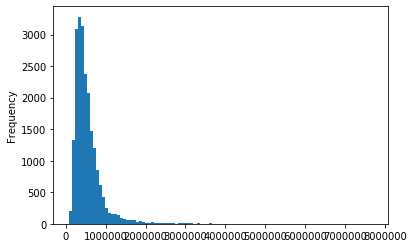

In [18]:
df['price'].plot(kind='hist', bins=100)

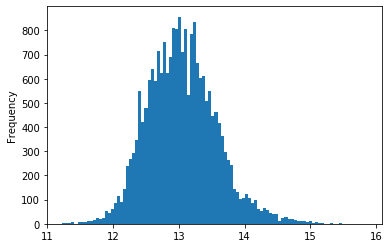

In [19]:
df['log_price'].plot(kind='hist', bins=100)

### price per square feet

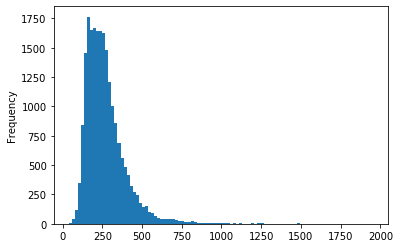

In [20]:
df['price_per_sqfeet'].plot(kind='hist', bins=100)

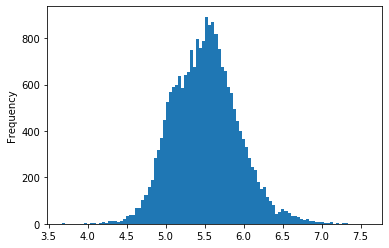

In [21]:
df['log_price_per_sqfeet'].plot(kind='hist', bins=100)

### price_bin


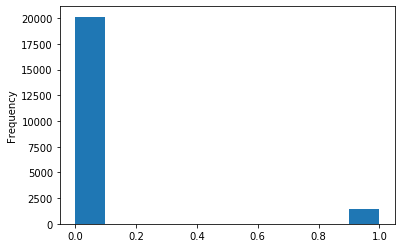

In [22]:
df['price_bin'].plot(kind='hist')

In [23]:
df['price_bin'].value_counts()

0    20148
1     1465
Name: price_bin, dtype: int64

In [24]:
df['price_bin'].mean()

0.06778327858233471

## Geography

In [25]:
WA_shapefile_path = os.path.join(external_data_path, 'WA_counties', 'WA_County_Boundaries.shx')
WA_shape = gpd.read_file(WA_shapefile_path)

def print_map(pd_df, color_column='price'):
    geometry = [Point(xy) for xy in zip(pd_df['long'], pd_df['lat'])]
    gdf = GeoDataFrame(pd_df, geometry=geometry)
    gdf.plot(ax=WA_shape.loc[WA_shape['JURISDIC_2']=='King'].plot(figsize=(16, 9)),
             column=pd_df[color_column], marker='o', cmap='jet', markersize=1)
    plt.xlim(-122.6, -121.0)
    plt.ylim(47.0, 47.8)

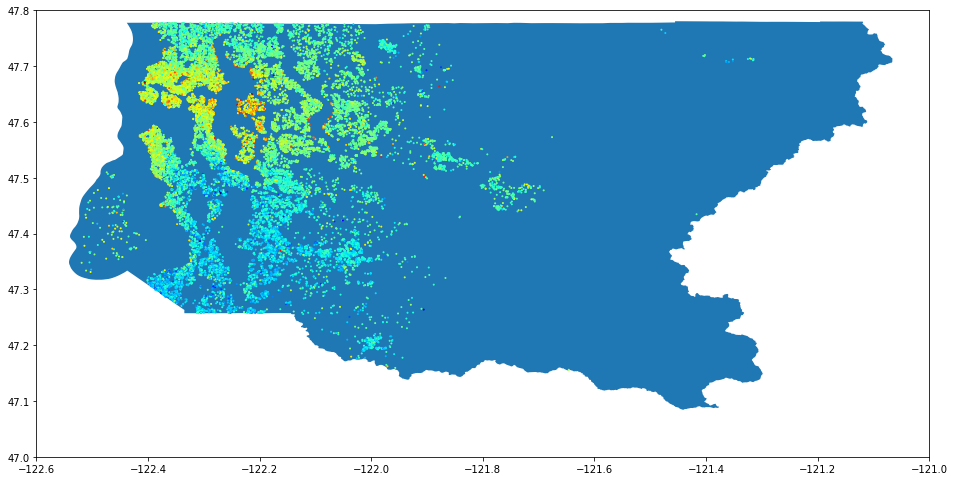

In [26]:
print_map(df, color_column='log_price_per_sqfeet')

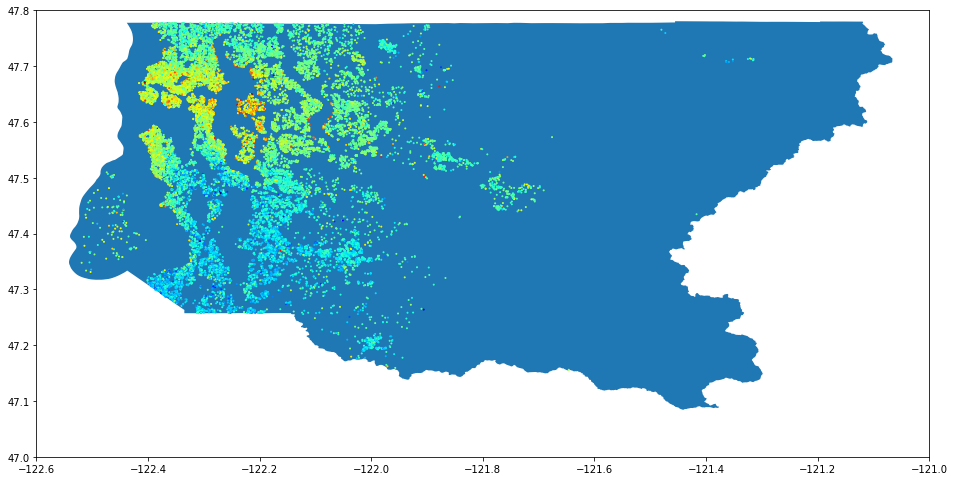

In [27]:
print_map(df, color_column='scaled_log_price_per_sqfeet')

# ====== how many unique values ======

## latitude & longitude

In [67]:
len(sorted(df['long'].unique()))

752

In [68]:
len(sorted(df['lat'].unique()))

5034

In [69]:
sorted(df['lat'].unique())

[47.1559,
 47.1593,
 47.1622,
 47.1647,
 47.1764,
 47.1775,
 47.1776,
 47.1795,
 47.1803,
 47.1808,
 47.184,
 47.1853,
 47.1879,
 47.1895,
 47.1896,
 47.19,
 47.1903,
 47.1913,
 47.1923,
 47.1924,
 47.1927,
 47.1928,
 47.1932,
 47.1934,
 47.1936,
 47.1937,
 47.1938,
 47.193999999999996,
 47.1941,
 47.1942,
 47.1943,
 47.1944,
 47.1946,
 47.1947,
 47.1948,
 47.1949,
 47.1951,
 47.1952,
 47.1955,
 47.1956,
 47.1958,
 47.1959,
 47.196000000000005,
 47.1963,
 47.1964,
 47.1967,
 47.1969,
 47.1976,
 47.1981,
 47.1983,
 47.1985,
 47.1986,
 47.1991,
 47.1996,
 47.2003,
 47.2004,
 47.2005,
 47.2008,
 47.201,
 47.2012,
 47.2015,
 47.2016,
 47.202,
 47.2021,
 47.2025,
 47.2026,
 47.2027,
 47.2032,
 47.2034,
 47.2039,
 47.2041,
 47.2043,
 47.2046,
 47.2048,
 47.205,
 47.2051,
 47.2052,
 47.2053,
 47.2056,
 47.2057,
 47.2058,
 47.206,
 47.2062,
 47.2063,
 47.2064,
 47.2068,
 47.2069,
 47.2073,
 47.2074,
 47.2077,
 47.2078,
 47.2079,
 47.208,
 47.2082,
 47.2083,
 47.2086,
 47.2087,
 47.2088,
 47.20

In [77]:
df['lat_len'] = df['lat'].apply(str).apply(len)

In [78]:
df['long_len'] = df['long'].apply(str).apply(len)

In [80]:
df['lat_len'].unique()

array([ 7, 18,  5,  6, 17,  4], dtype=int64)

In [81]:
df['long_len'].unique()

array([ 8, 19,  7,  6], dtype=int64)

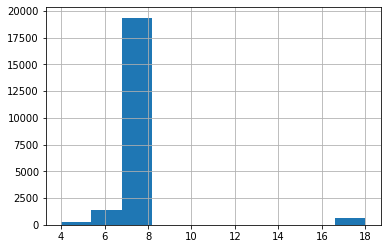

In [90]:
df['lat_len'].hist()

In [100]:
sorted(df.loc[df['lat_len'] == 7, 'lat'])

[47.1559,
 47.1593,
 47.1622,
 47.1647,
 47.1764,
 47.1775,
 47.1776,
 47.1776,
 47.1795,
 47.1803,
 47.1808,
 47.1853,
 47.1879,
 47.1895,
 47.1896,
 47.1896,
 47.1903,
 47.1913,
 47.1913,
 47.1923,
 47.1924,
 47.1927,
 47.1927,
 47.1927,
 47.1928,
 47.1932,
 47.1934,
 47.1936,
 47.1937,
 47.1937,
 47.1937,
 47.1938,
 47.1941,
 47.1941,
 47.1942,
 47.1942,
 47.1943,
 47.1944,
 47.1944,
 47.1946,
 47.1946,
 47.1947,
 47.1947,
 47.1948,
 47.1948,
 47.1948,
 47.1948,
 47.1949,
 47.1949,
 47.1949,
 47.1951,
 47.1951,
 47.1952,
 47.1952,
 47.1955,
 47.1955,
 47.1955,
 47.1956,
 47.1956,
 47.1958,
 47.1958,
 47.1958,
 47.1958,
 47.1959,
 47.1963,
 47.1964,
 47.1967,
 47.1967,
 47.1969,
 47.1976,
 47.1981,
 47.1983,
 47.1985,
 47.1986,
 47.1991,
 47.1996,
 47.2003,
 47.2004,
 47.2005,
 47.2008,
 47.2012,
 47.2015,
 47.2015,
 47.2016,
 47.2021,
 47.2021,
 47.2021,
 47.2025,
 47.2026,
 47.2027,
 47.2032,
 47.2034,
 47.2039,
 47.2041,
 47.2043,
 47.2043,
 47.2046,
 47.2046,
 47.2048,
 47.2051,


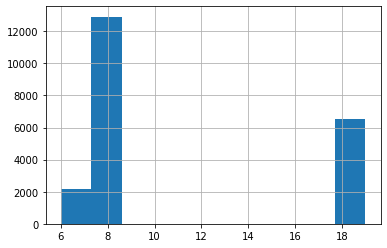

In [91]:
df['long_len'].hist()

In [98]:
sorted(df.loc[df['long_len'] == 8, 'long'])

[-122.515,
 -122.514,
 -122.512,
 -122.509,
 -122.509,
 -122.507,
 -122.506,
 -122.505,
 -122.505,
 -122.505,
 -122.499,
 -122.491,
 -122.486,
 -122.484,
 -122.479,
 -122.475,
 -122.475,
 -122.473,
 -122.469,
 -122.465,
 -122.465,
 -122.465,
 -122.464,
 -122.464,
 -122.464,
 -122.464,
 -122.464,
 -122.463,
 -122.463,
 -122.463,
 -122.463,
 -122.463,
 -122.463,
 -122.462,
 -122.462,
 -122.462,
 -122.462,
 -122.461,
 -122.461,
 -122.461,
 -122.461,
 -122.459,
 -122.458,
 -122.456,
 -122.456,
 -122.456,
 -122.455,
 -122.455,
 -122.455,
 -122.454,
 -122.449,
 -122.449,
 -122.448,
 -122.447,
 -122.446,
 -122.446,
 -122.446,
 -122.446,
 -122.446,
 -122.445,
 -122.445,
 -122.444,
 -122.444,
 -122.444,
 -122.443,
 -122.443,
 -122.443,
 -122.441,
 -122.439,
 -122.439,
 -122.435,
 -122.432,
 -122.431,
 -122.425,
 -122.425,
 -122.421,
 -122.416,
 -122.416,
 -122.416,
 -122.416,
 -122.415,
 -122.415,
 -122.415,
 -122.415,
 -122.415,
 -122.414,
 -122.414,
 -122.414,
 -122.414,
 -122.414,
 -122.413,

In [79]:
df[['lat','long','lat_len','long_len']]

,lat,long,lat_len,long_len
0,47.5112,-122.257,7,8
1,47.7210,-122.319,18,8
2,47.7379,-122.233,7,19
3,47.5208,-122.393,7,19
4,47.6168,-122.045,7,8
5,47.6561,-122.005,7,8
6,47.3097,-122.327,7,19
7,47.4095,-122.315,7,8
8,47.5123,-122.337,7,8
9,47.3684,-122.031,7,8


In [102]:
df['long_rounded'] = round(df['long'],3)
df['lat_rounded'] = round(df['lat'],4)

In [115]:
df['long_rounded'].min(), df['long_rounded'].max(), df['long_rounded'].max() - df['long_rounded'].min()

(-122.519, -121.315, 1.2040000000000077)

In [114]:
df['lat_rounded'].min(), df['lat_rounded'].max(), df['lat_rounded'].max() - df['lat_rounded'].min()

(47.1559, 47.7776, 0.621699999999997)

X    Y

long lat

1204 6217

In [121]:
np.linspace(0,1,num=1204)

array([0.00000000e+00, 8.31255195e-04, 1.66251039e-03, ...,
       9.98337490e-01, 9.99168745e-01, 1.00000000e+00])

In [ ]:
np.linspace(0,1,num=1204)
np.linspace(0,1,num=6217)

In [123]:
scaler_long.min_

array([101.75996678])

## price

In [28]:
len(df['scaled_log_price_per_sqfeet'].unique())

16392

# =======================================

## Interpolation

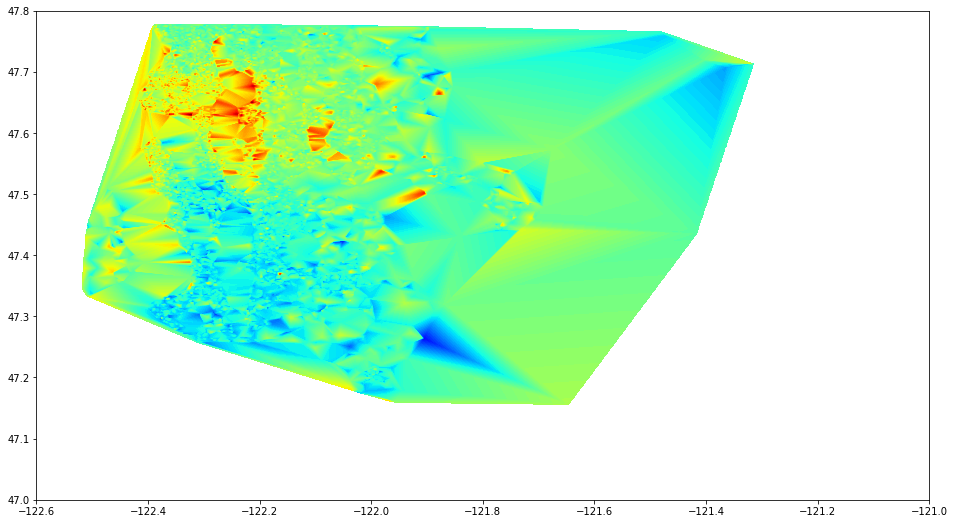

In [30]:
# data coordinates and values
x = df['scaled_long']
y = df['scaled_lat']
z = df['scaled_log_price_per_sqfeet']

# target grid to interpolate to
xi = np.linspace(0,1,num=1204)
yi = np.linspace(0,1,num=6217)
#xi = yi = np.arange(0,1.01,0.01)
xi,yi = np.meshgrid(xi,yi)

# set mask
#mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='linear', rescale=False)

xi_i = scaler_long.inverse_transform(xi)
yi_i = scaler_lat.inverse_transform(yi)
zi_i = scaler_log_price_per_sqfeet.inverse_transform(zi)
# mask out the field
#zi[mask] = np.nan

# plot
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
plt.contourf(xi_i,yi_i,zi,np.arange(0,1.01,0.01), cmap='jet')
plt.plot(x,y,'k.')
#plt.xlabel('xi',fontsize=16)
#plt.ylabel('yi',fontsize=16)
plt.xlim((-122.6, -121.0))
plt.ylim((47.0, 47.8))
plt.savefig('interpolated.png',dpi=100)
plt.show()
#plt.close(fig)

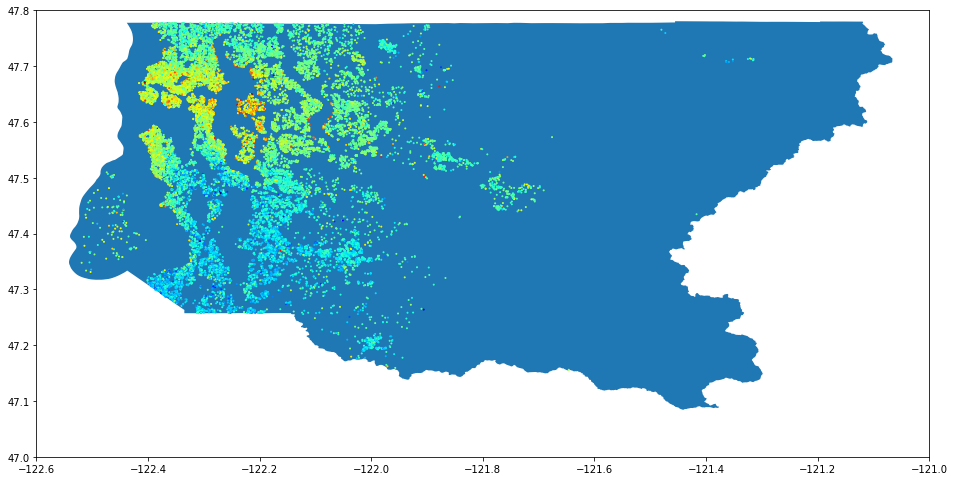

In [31]:
print_map(df, color_column='scaled_log_price_per_sqfeet')

In [77]:
df.loc[df['scaled_log_price_per_sqfeet'] == df['scaled_log_price_per_sqfeet'].max()]

,id,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqfeet,log_price,log_price_per_sqfeet,price_year,price_month,scaled_long,scaled_lat,scaled_price,scaled_log_price,scaled_price_per_sqfeet,scaled_log_price_per_sqfeet,geometry
7252,6762700020,2014-10-13,7700000.0,1,6,8.0,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,1954.314721,15.856731,7.577795,2014,10,0.162791,0.762265,1.0,1.0,1.0,1.0,POINT (-122.32300 47.62980)


In [38]:
def get_rounded_lat_long(row_index):
    return round(df.loc[row_index]['lat'], 4), round(df.loc[row_index]['long'], 3)

In [48]:
def griddata_pred(row_index, min_long = -122.5190, min_lat = 47.1559):
    lat_rounded, long_rounded = get_lat_long(row_index)
    print(long_rounded, lat_rounded)
    x = int(round((long_rounded - min_long)*1000))
    y = int(round((lat_rounded - min_lat)*1000))
    print(x, y)
    print(x, y, zi[x, y])
    print(x, y, zi[y, x])
    print(x, y, zi[x, 6217-y])
    print(x, y, zi[6217-y, x])
    log_price_per_sqfeet = 3
    price_per_sqfeet = np.exp(log_price_per_sqfeet)
    return price_per_sqfeet

In [51]:
griddata_pred(7252)

-122.323 47.6298
196 474
196 474 nan
196 474 nan


IndexError: index 5743 is out of bounds for axis 1 with size 1204

In [49]:
df.loc[7252]['lat']

47.6298

In [52]:
zi.shape

(6217, 1204)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D5872749B0>]],
      dtype=object)

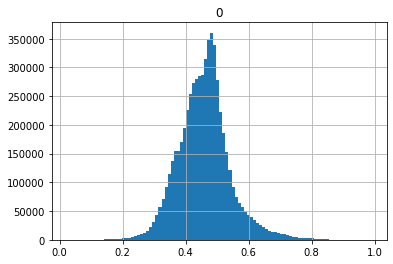

In [60]:
pd.DataFrame(zi.flatten()).hist(bins=100)

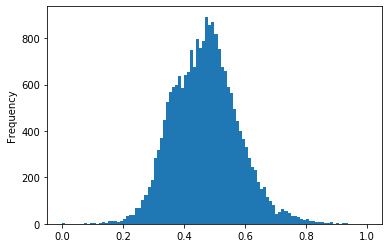

In [62]:
df['scaled_log_price_per_sqfeet'].plot(kind='hist', bins=100)

# ==================== main flow =====================

In [64]:
df_smp = df.sample(random_state=42)

In [ ]:
def feature_generation(df):
    df['price_per_sqfeet'] = df['price']/df['sqft_living15']
    df['log_price'] = np.log(df['price'])
    df['log_price_per_sqfeet'] = np.log(df['price_per_sqfeet'])
    df['price_year'] = df['date'].dt.year
    df['price_month'] = df['date'].dt.month
 
    scaler = MinMaxScaler()
    #df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    scaler_long = MinMaxScaler()
    df['scaled_long'] = scaler_long.fit_transform(df[['long']])
    scaler_lat = MinMaxScaler()
    df['scaled_lat'] = scaler_lat.fit_transform(df[['lat']])
    df['scaled_price'] = scaler.fit_transform(df[['price']])
    df['scaled_log_price'] = scaler.fit_transform(df[['log_price']])
    df['scaled_price_per_sqfeet'] = scaler.fit_transform(df[['price_per_sqfeet']])
    scaler_log_price_per_sqfeet = MinMaxScaler()
    df['scaled_log_price_per_sqfeet'] = scaler_log_price_per_sqfeet.fit_transform(df[['log_price_per_sqfeet']])
    return df

In [ ]:
def predict_price_per_sqfeet(df):
    pass

In [ ]:
def predict_total_price(df):
    pass

In [ ]:
def is_million(df):
    if df['price_pred'] >= 1000000:
        df['price_bin_pred'] = 1
    else:
        df['price_bin_pred'] = 0

In [ ]:
def has_

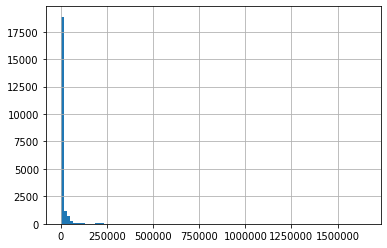

In [72]:
df['sqft_lot'].hist(bins=100)

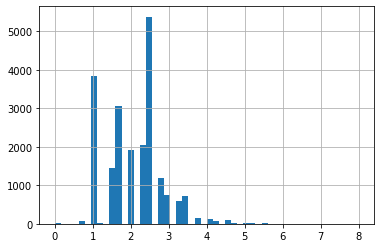

In [79]:
df['bathrooms'].hist(bins=50)

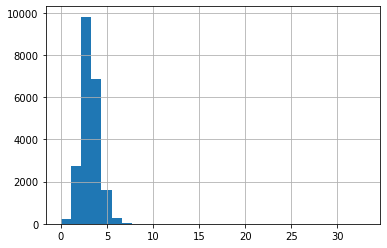

In [90]:
df['bedrooms'].hist(bins=30)

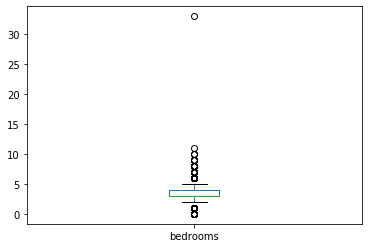

In [91]:
df['bedrooms'].plot(kind='box')

In [94]:
df_org = pd.read_csv(house_data_path, low_memory=False, parse_dates=dateColumns, infer_datetime_format=True)

In [95]:
X = df_org.drop(['date', 'lat', 'long'])

,id,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [97]:
list(df_org.columns)

['id',
 'date',
 'price',
 'price_bin',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [ ]:
df.drop()

In [ ]:
import pandas as pd
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

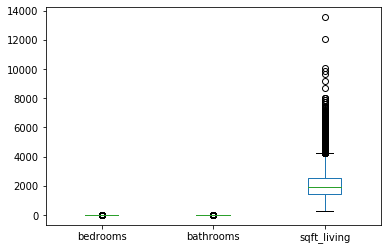

In [93]:
df[['bedrooms','bathrooms', 'sqft_living']].plot(kind='box')

In [66]:
df.loc[df['price_bin']==1].sort_values('price')

,id,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqfeet,log_price,log_price_per_sqfeet,price_year,price_month,scaled_long,scaled_lat,scaled_price,scaled_log_price,scaled_price_per_sqfeet,scaled_log_price_per_sqfeet,geometry
8177,1257200115,2014-05-21,1000000.0,1,4,2.75,2290,6120,2.0,0,0,4,7,2170,120,1926,0,98115,47.6746,-122.327,1910,4590,523.560209,13.815511,6.260652,2014,5,0.159468,0.834325,0.121311,0.559273,0.252792,0.662370,POINT (-122.32700 47.67460)
3282,2125059112,2015-03-26,1000000.0,1,5,2.50,3150,50094,2.0,0,0,4,9,3150,0,1969,0,98005,47.6387,-122.177,3600,48787,277.777778,13.815511,5.626821,2015,3,0.284053,0.776580,0.121311,0.559273,0.124433,0.499898,POINT (-122.17700 47.63870)
19194,1337800220,2014-09-08,1000000.0,1,4,2.50,2230,3600,2.0,0,0,5,8,1630,600,1906,0,98112,47.6304,-122.309,2410,4800,414.937759,13.815511,6.028129,2014,9,0.174419,0.763230,0.121311,0.559273,0.196064,0.602767,POINT (-122.30900 47.63040)
19024,6815100085,2014-12-24,1000000.0,1,4,2.00,3100,8000,1.5,0,0,5,7,2040,1060,1939,0,98103,47.6852,-122.329,1650,4000,606.060606,13.815511,6.406980,2014,12,0.157807,0.851375,0.121311,0.559273,0.295878,0.699879,POINT (-122.32900 47.68520)
2717,9808590310,2015-04-08,1000000.0,1,3,2.75,3070,10739,2.0,0,0,3,10,2440,630,1987,0,98004,47.6444,-122.191,3490,11913,286.532951,13.815511,5.657854,2015,4,0.272425,0.785749,0.121311,0.559273,0.129005,0.507852,POINT (-122.19100 47.64440)
21606,7936000429,2015-03-26,1010000.0,1,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200,492.682927,13.825461,6.199866,2015,3,0.100498,0.639858,0.122623,0.561422,0.236666,0.646789,POINT (-122.39800 47.55370)
891,1962200435,2014-11-10,1010000.0,1,4,1.00,1820,5400,1.5,0,0,3,8,1820,0,1923,2014,98102,47.6476,-122.318,1820,5400,554.945055,13.825461,6.318869,2014,11,0.166944,0.790896,0.122623,0.561422,0.269183,0.677294,POINT (-122.31800 47.64760)
14192,723000150,2015-04-08,1010000.0,1,3,2.50,2570,5000,1.0,0,0,4,8,1480,1090,1940,0,98105,47.6578,-122.285,2420,5484,417.355372,13.825461,6.033938,2015,4,0.194352,0.807303,0.122623,0.561422,0.197327,0.604256,POINT (-122.28500 47.65780)
14356,1245500730,2014-12-08,1010000.0,1,5,3.25,3510,10930,2.0,0,0,3,9,3510,0,2013,0,98033,47.6914,-122.210,1970,7488,512.690355,13.825461,6.239672,2014,12,0.256645,0.861348,0.122623,0.561422,0.247115,0.656993,POINT (-122.21000 47.69140)
2931,7977201240,2015-03-11,1010000.0,1,4,3.50,3500,4080,2.0,0,2,3,9,2590,910,2004,0,98115,47.6834,-122.292,2430,5100,415.637860,13.825461,6.029814,2015,3,0.188538,0.848480,0.122623,0.561422,0.196430,0.603199,POINT (-122.29200 47.68340)


# =====================

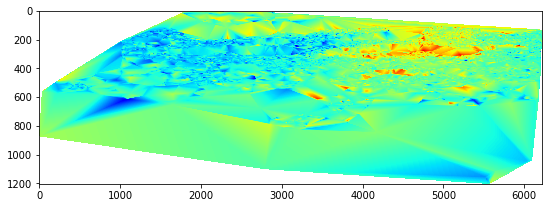

In [33]:
plt.figure(figsize=(9,16))
plt.imshow(zi.T, cmap='jet', aspect=16/9)

In [71]:
h = [
    [0,0,0,0,0],
    [0,0,0,1,0],
    [np.nan,np.nan,np.nan,np.nan,np.nan]
    ]

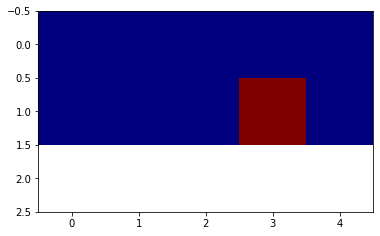

In [72]:
plt.imshow(h, cmap='jet')

# =====================

In [198]:
test_cols = pd.DataFrame()
test_cols['org'] = list(range(51))

In [199]:
col_scaler = MinMaxScaler()

In [200]:
test_cols['scaled'] = col_scaler.fit_transform(test_cols[['org']])

In [202]:
test_cols.head()

,org,scaled
0,0,0.00
1,1,0.02
2,2,0.04
3,3,0.06
4,4,0.08


In [205]:
test_cols['back_org'] = col_scaler.inverse_transform(test_cols[['scaled']])

In [206]:
test_cols.head()

,org,scaled,back_org
0,0,0.00,0.0
1,1,0.02,1.0
2,2,0.04,2.0
3,3,0.06,3.0
4,4,0.08,4.0


# &&&&&&&&&&&&&&&&&&&&&&

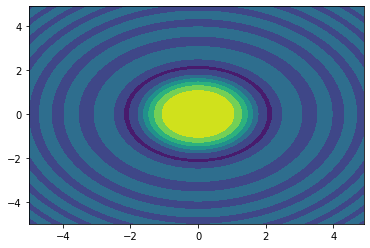

In [31]:
import matplotlib.pyplot as plt
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
h = plt.contourf(x,y,z)
plt.show()

In [ ]:
plt.contourf()

## Timeseries

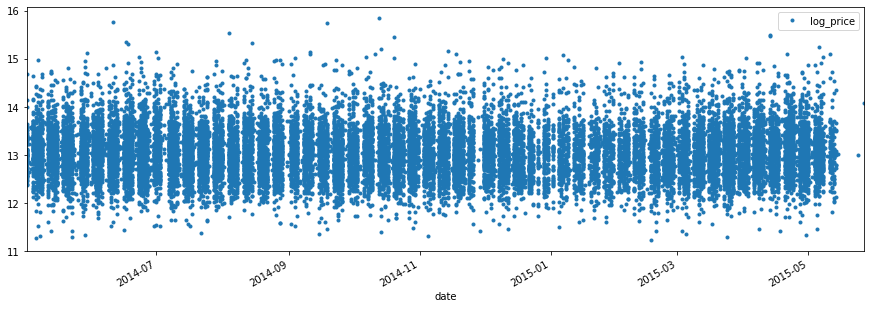

In [22]:
df.plot(x='date', y='log_price', style='.', figsize=(15,5))

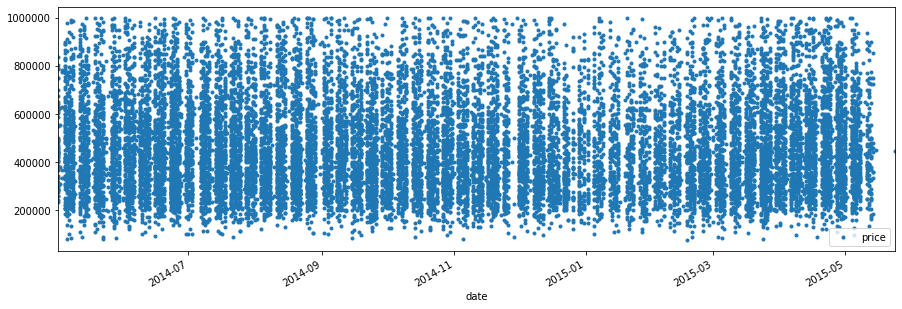

In [20]:
df_low.plot(x='date', y='price', style='.', figsize=(15,5))

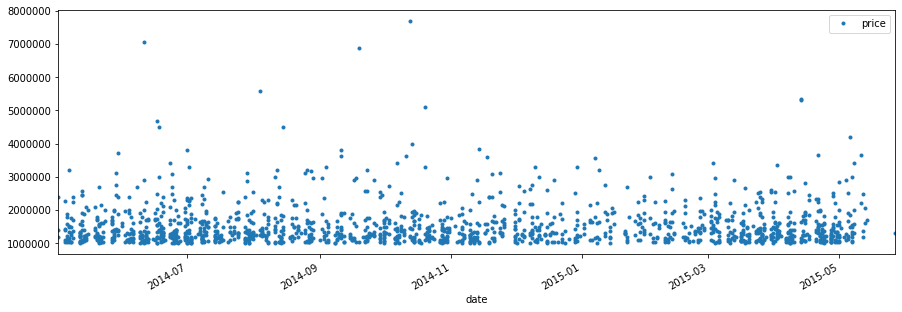

In [21]:
df_high.plot(x='date', y='price', style='.', figsize=(15,5))

In [24]:
df['date'].min()

Timestamp('2014-05-02 00:00:00')

In [25]:
df['date'].max()

Timestamp('2015-05-27 00:00:00')

In [47]:
data = df_low

    prices per month per year

In [48]:
month_pivot = pd.pivot_table(data, values='id', index=['price_year','price_month'], aggfunc='count')
month_norm = pd.DataFrame(month_pivot.unstack().T.sum(), columns=['sum'])

In [49]:
month_pivot

id
price_year price_month      
2014       5            1638
           6            2016
           7            2050
           8            1828
           9            1677
           10           1743
           11           1322
           12           1373
2015       1             917
           2            1180
           3            1735
           4            2067
           5             602

    Amount of loan in years
    Loan amount by month

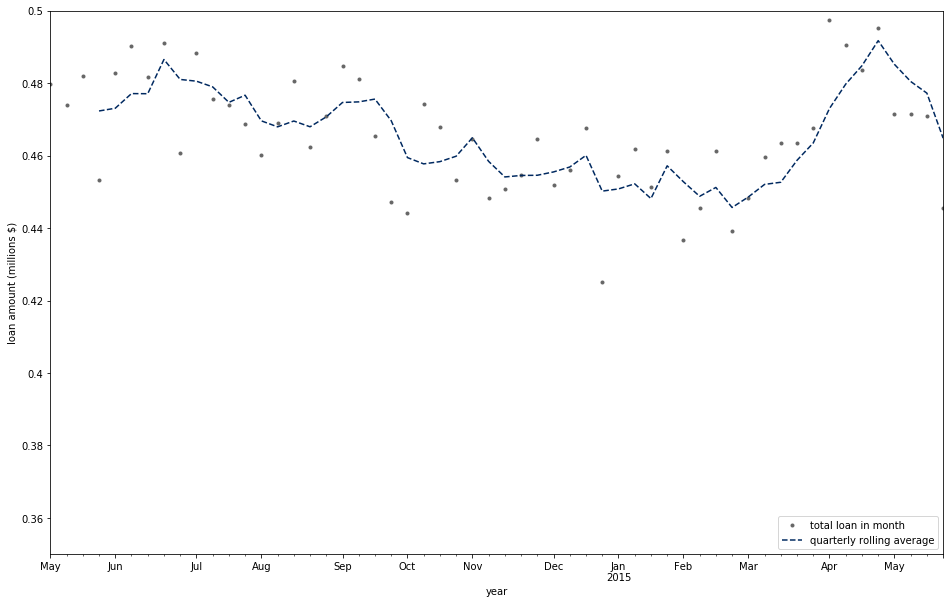

In [153]:
price_mean_weakly = data[['date','price']].set_index('date').resample('W').mean()
ma = price_mean_weakly.rolling(window=4).mean()
mstd = price_mean_weakly.rolling(window=4).std()
ax = price_mean_weakly.plot(style='.',figsize=(16,10), color='#666666')
ma.plot(style = '--', ax=ax, color='#002960',  ylim=(350000,500000))

scale_y = 1e6
ticks_y = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
#plt.title('aaa')
plt.xlabel('year')
plt.ylabel('loan amount (millions $)')
plt.legend(labels=['total loan in month','quarterly rolling average'], loc='lower right')
plt.savefig(os.path.join(figures_data_path, 'Fig2.png'), bbox_inches='tight')
plt.show()

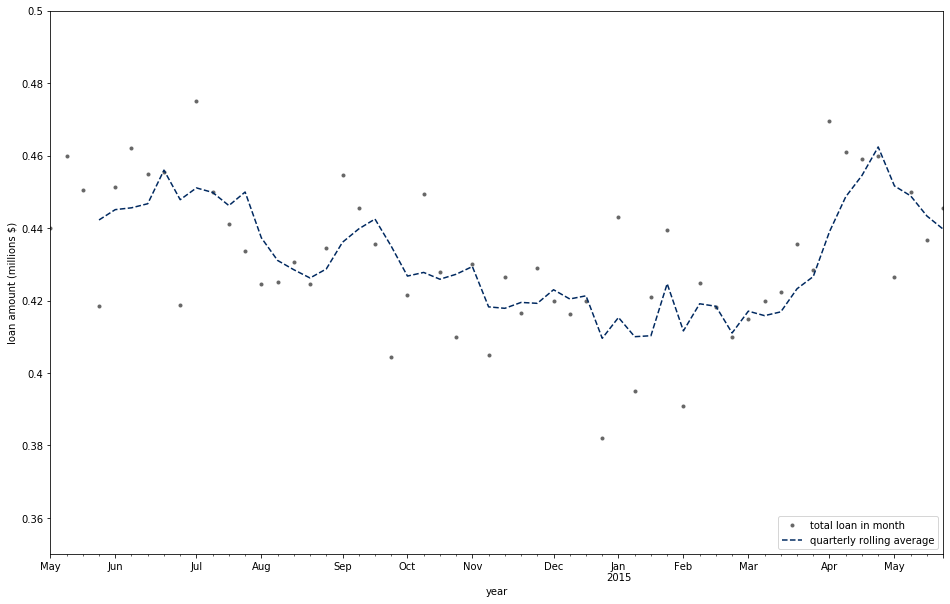

In [152]:
price_median_weakly = data[['date','price']].set_index('date').resample('W').median()
ma = price_median_weakly.rolling(window=4).mean()
mstd = price_median_weakly.rolling(window=4).std()
ax = price_median_weakly.plot(style='.',figsize=(16,10), color='#666666')
ma.plot(style = '--', ax=ax, color='#002960', ylim=(350000,500000))

scale_y = 1e6
ticks_y = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
#plt.title('aaa')
plt.xlabel('year')
plt.ylabel('loan amount (millions $)')
plt.legend(labels=['total loan in month','quarterly rolling average'], loc='lower right')
plt.savefig(os.path.join(figures_data_path, 'Fig2.png'), bbox_inches='tight')
plt.show()

    Avrage amount of loan is increasing but stabilizing around 15k USD
    Average loan amount by month

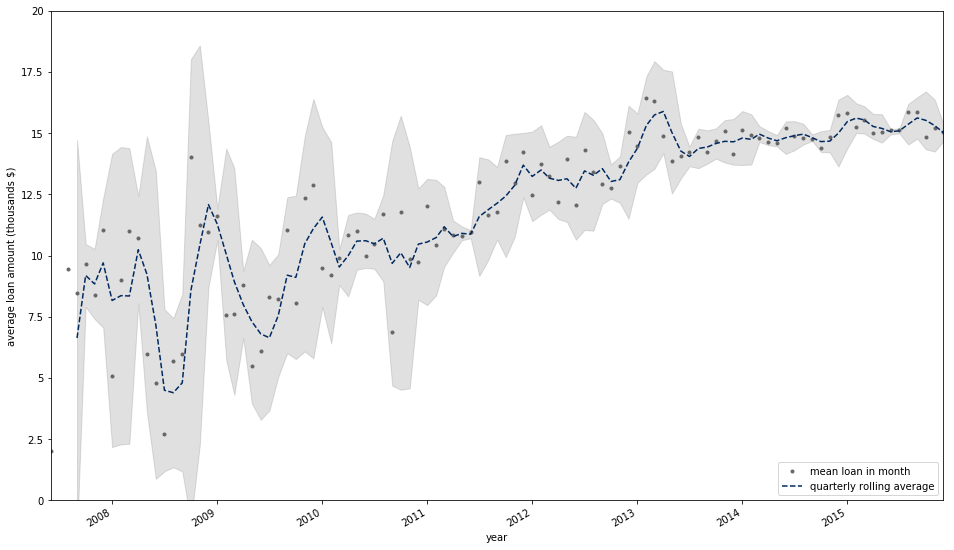

In [13]:
loan_amnt_mnth_mean = pd.pivot_table(data,values='loan_amnt', columns='issue_d',aggfunc='mean').T
ma = loan_amnt_mnth_mean.rolling(window=3).mean()
mstd = loan_amnt_mnth_mean.rolling(window = 3).std()
ax = loan_amnt_mnth_mean.plot(style='.', figsize=(16,10),ylim=(0,20000), color='#666666')
ma.plot(style = '--', ax=ax, color='#002960')
plt.fill_between(mstd.index, y1=ma['loan_amnt'].values-2*mstd['loan_amnt'].values, y2=ma['loan_amnt'].values+2*mstd['loan_amnt'].values, color='#666666', alpha=0.2)

scale_y = 1e3
ticks_y = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
#plt.title('aaa')
plt.xlabel('year')
plt.ylabel('average loan amount (thousands $)')
plt.legend(labels=['mean loan in month','quarterly rolling average'], loc='lower right')
plt.savefig(os.path.join(figures_data_path, 'Fig3.png'), bbox_inches='tight')
plt.show()

In [ ]:
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
groups = series.groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.boxplot()
pyplot.show()

In [ ]:
# create a boxplot of monthly data
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
from pandas import concat
series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
one_year = series['1990']
groups = one_year.groupby(Grouper(freq='M'))
months = concat([DataFrame(x[1].values) for x in groups], axis=1)
months = DataFrame(months)
months.columns = range(1,13)
months.boxplot()
pyplot.show()

# ================

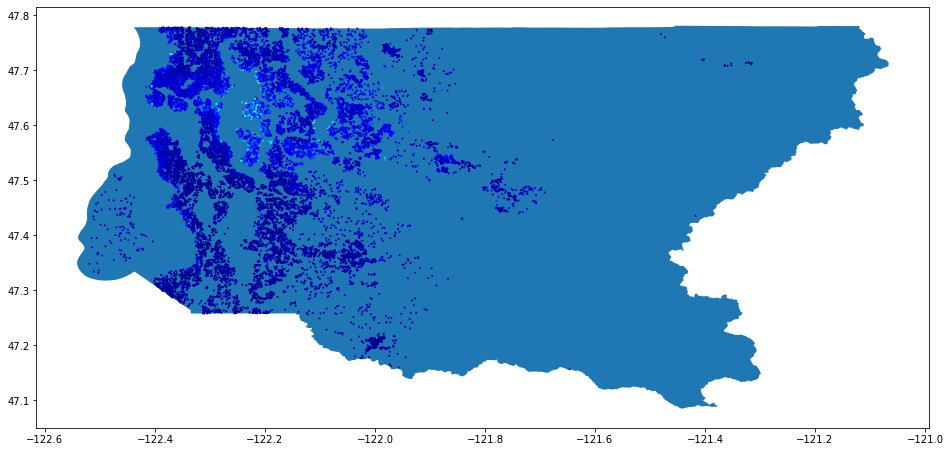

In [34]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)   

#this is a simple map that goes with geopandas

#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

WA_shapefile_path = os.path.join(external_data_path, 'WA_counties', 'WA_County_Boundaries.shx')
WA_shape = gpd.read_file(WA_shapefile_path)

#gdf.plot(ax=WA_shape.loc[WA_shape['JURISDIC_2']=='King'].plot(figsize=(16, 9)), marker='o', color='red', markersize=1)
gdf.plot(ax=WA_shape.loc[WA_shape['JURISDIC_2']=='King'].plot(figsize=(16, 9)), column=df['price'], marker='o', cmap='jet', markersize=1)

In [ ]:
gdf = GeoDataFrame(df, geometry=geometry)   

#this is a simple map that goes with geopandas

#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

WA_shapefile_path = os.path.join(external_data_path, 'WA_counties', 'WA_County_Boundaries.shx')
WA_shape = gpd.read_file(WA_shapefile_path)

#gdf.plot(ax=WA_shape.loc[WA_shape['JURISDIC_2']=='King'].plot(figsize=(16, 9)), marker='o', color='red', markersize=1)
gdf.plot(ax=WA_shape.loc[WA_shape['JURISDIC_2']=='King'].plot(figsize=(16, 9)), column=df['price'], marker='o', cmap='jet', markersize=1)

In [36]:
df.head().T

,0,1,2,3,4
id,7129300520,6414100192,5631500400,2487200875,1954400510
date,2014-10-13 00:00:00,2014-12-09 00:00:00,2015-02-25 00:00:00,2014-12-09 00:00:00,2015-02-18 00:00:00
price,221900,538000,180000,604000,510000
price_bin,0,0,0,0,0
bedrooms,3,3,2,4,3
bathrooms,1,2.25,1,3,2
sqft_living,1180,2570,770,1960,1680
sqft_lot,5650,7242,10000,5000,8080
floors,1,2,1,1,1
waterfront,0,0,0,0,0


In [5]:
df = pd.read_csv(loan_data_path, low_memory=False, parse_dates=dateColumns, infer_datetime_format=True)

    Loan amount by grade

In [14]:
grade_pivot = pd.pivot_table(data,values='id',index=['grade','sub_grade'], aggfunc='count')

In [15]:
grade_pivot_default = pd.pivot_table(data,values='Default',index=['grade','sub_grade'], aggfunc='sum')

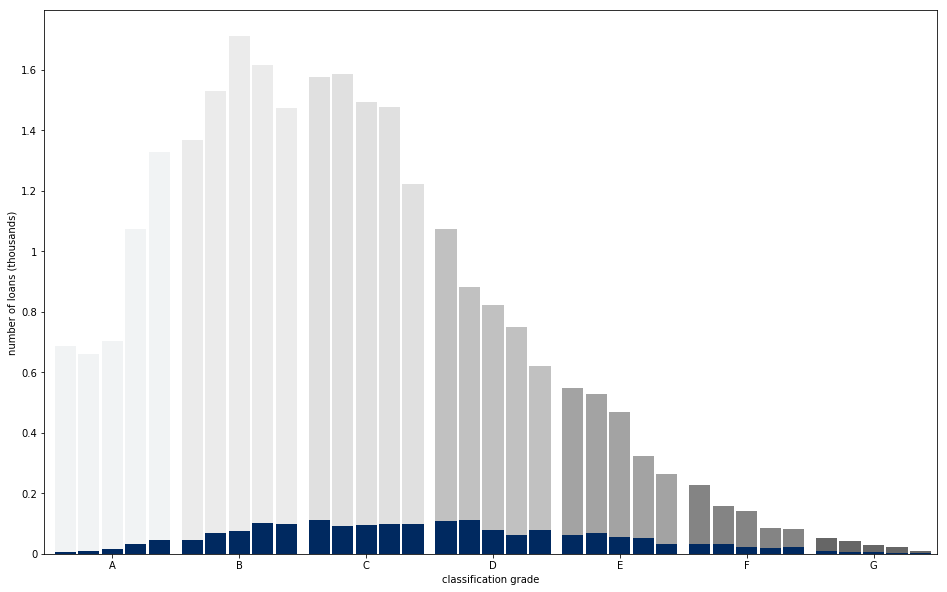

In [16]:
w=0.9
ax = grade_pivot.query('grade == ["A"]').plot(kind='bar',color='#F1F3F4',width=w,position=0,stacked=False, align = 'edge',legend=False,  figsize=(16,10), use_index=False)
grade_pivot.query('grade == ["B"]').plot(kind='bar',color='#EBEBEB',width=w,position=-6,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot.query('grade == ["C"]').plot(kind='bar',color='#666666',alpha=0.2,width=w,position=-12,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot.query('grade == ["D"]').plot(kind='bar',color='#666666',alpha=0.4,width=w,position=-18,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot.query('grade == ["E"]').plot(kind='bar',color='#666666',alpha=0.6,width=w,position=-24,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot.query('grade == ["F"]').plot(kind='bar',color='#666666',alpha=0.8,width=w,position=-30,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot.query('grade == ["G"]').plot(kind='bar',color='#666666',width=w,position=-36,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)

default_color = '#002960'
grade_pivot_default.query('grade == ["A"]').plot(kind='bar',color=default_color,width=w,position=0,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot_default.query('grade == ["B"]').plot(kind='bar',color=default_color,width=w,position=-6,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot_default.query('grade == ["C"]').plot(kind='bar',color=default_color,width=w,position=-12,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot_default.query('grade == ["D"]').plot(kind='bar',color=default_color,width=w,position=-18,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot_default.query('grade == ["E"]').plot(kind='bar',color=default_color,width=w,position=-24,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot_default.query('grade == ["F"]').plot(kind='bar',color=default_color,width=w,position=-30,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)
grade_pivot_default.query('grade == ["G"]').plot(kind='bar',color=default_color,width=w,position=-36,stacked=False, align = 'edge',legend=False, use_index=False, ax=ax)

bars = ('A', 'B', 'C', 'D', 'E', 'F', 'G')
y_pos = [2.9,8.3,13.7,19.1,24.5,29.9,35.3]

scale_y = 1e3
ticks_y = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)

plt.xticks(rotation=0)
plt.xticks(y_pos, bars)
#plt.title('aaa')
plt.xlabel('classification grade')
plt.ylabel('number of loans (thousands)')
plt.savefig(os.path.join(figures_data_path, 'Fig4.png'), bbox_inches='tight')
plt.show()

    Distribution of purpose segmantated by years

In [17]:
purpose_pivot = pd.pivot_table(data,values='id',index=['issue_year','purpose'], aggfunc='count')
purpose_norm = pd.DataFrame(purpose_pivot.unstack().T.sum(), columns=['sum'])

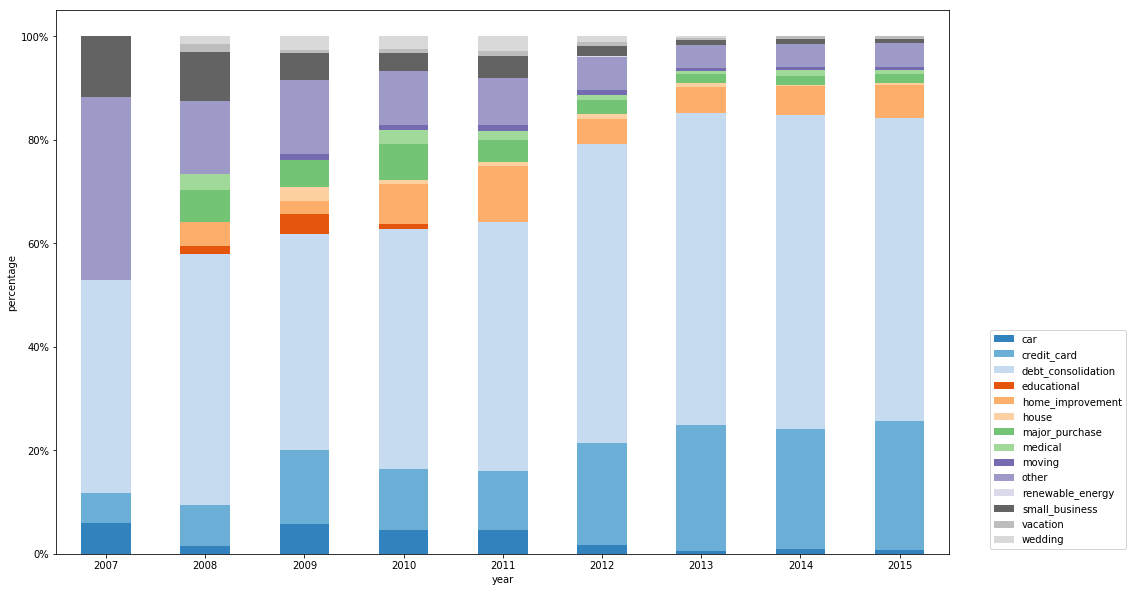

In [18]:
from matplotlib.ticker import FuncFormatter
leg_leb=data['purpose'].value_counts().sort_index().index
ax = purpose_pivot.unstack().divide(purpose_norm['sum'],axis=0).plot(kind='bar',stacked=True, figsize=(16,10),colormap='tab20c')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xticks(rotation=0)
plt.xlabel('year')
plt.ylabel('percentage')
plt.legend(leg_leb,bbox_to_anchor=(1.04,0), loc='lower left')
plt.savefig(os.path.join(figures_data_path, 'Fig5.png'), bbox_inches='tight')
plt.show()

    Purpose rectangle (treemap) map (color represent avrage amount of loan by type)

In [19]:
data['purpose'].value_counts()/data.shape[0]

debt_consolidation    0.587731
credit_card           0.233350
home_improvement      0.059577
other                 0.049134
major_purchase        0.019834
small_business        0.011532
car                   0.010368
medical               0.009241
moving                0.006123
vacation              0.004921
house                 0.004696
wedding               0.002667
educational           0.000413
renewable_energy      0.000413
Name: purpose, dtype: float64

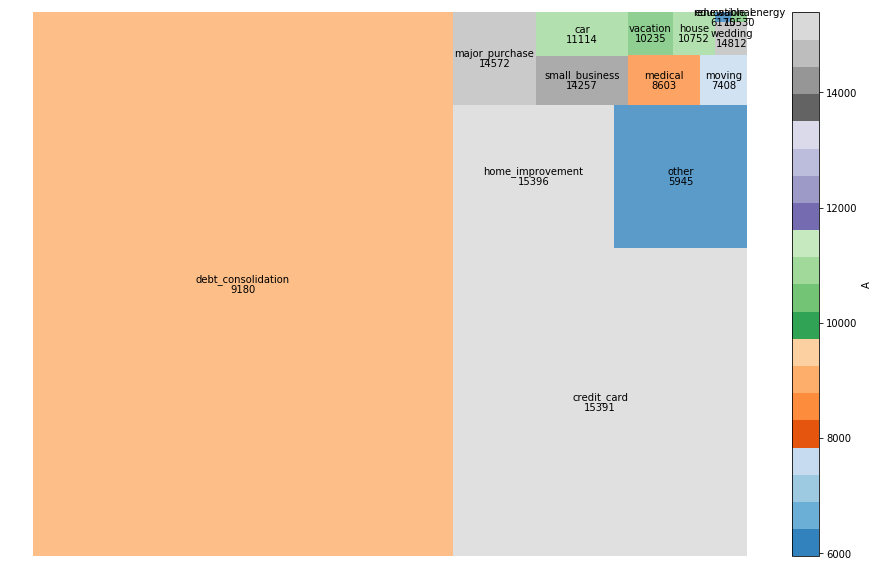

In [20]:
# libraries
import matplotlib
import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)

purpose_sizes = data['purpose'].value_counts().values
purpose_values= data.groupby(by='purpose')['loan_amnt'].mean().values.astype(int)
purpose_labels= data['purpose'].value_counts().index

# create a color palette, mapped to these values
cmap = matplotlib.cm.tab20c
mini=min(purpose_values)
maxi=max(purpose_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in purpose_values]

plt.figure(figsize=(16, 10))
# If you have a data frame?
squarify.plot(sizes= purpose_sizes, label=purpose_labels, alpha=.8, value=purpose_values,color=colors)
plt.axis('off')

img = plt.imshow([purpose_values], cmap=cmap,aspect='auto')
img.set_visible(False)

#cax = plt.axes([0.95, 0.1, 0.02, 0.5])

plt.colorbar(img, orientation="vertical", label='A')
plt.savefig(os.path.join(figures_data_path, 'Fig6.png'), bbox_inches='tight')
plt.show() 

    Maps

In [21]:
import plotly.plotly as py
import plotly.graph_objs as go

In [22]:
import plotly
plotly.tools.set_credentials_file(username='USER', api_key='KEY')

In [23]:
state_count = pd.DataFrame(data['addr_state'].value_counts()).reset_index()
state_count.columns=['addr_state','state_count']

In [24]:
state_amnt = pd.pivot_table(data,values='loan_amnt',index=['addr_state'], aggfunc='sum').reset_index()
state_amnt.columns=['addr_state','state_amnt']

In [25]:
# state population from wiki https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population
state_pop = {'CA' : 39144818,
'TX' : 27469144,
'FL' : 20271878,
'NY' : 19795791,
'IL' : 12859995,
'PA' : 12802503,
'OH' : 11613423,
'GA' : 10214860,
'NC' : 10042802,
'MI' : 9922576,
'NJ' : 8958013,
'VA' : 8382993,
'WA' : 7170351,
'AZ' : 6828065,
'MA' : 6794422,
'IN' : 6619680,
'TN' : 6600299,
'MO' : 6083672,
'MD' : 6006401,
'WI' : 5771337,
'MN' : 5489594,
'CO' : 5456574,
'SC' : 4896146,
'AL' : 4858979,
'LA' : 4670724,
'KY' : 4425092,
'OR' : 4028977,
'OK' : 3911338,
'CT' : 3890886,
'IA' : 3123899,
'UT' : 2995919,
'MS' : 2992333,
'AR' : 2978204,
'KS' : 2911641,
'NV' : 2890845,
'NM' : 2085109,
'NE' : 1896190,
'WV' : 1844128,
'ID' : 1654930,
'HI' : 1431603,
'NH' : 1330608,
'ME' : 1329328,
'RI' : 1053298,
'MT' : 1032949,
'DE' : 945934,
'SD' : 858469,
'ND' : 756927,
'AK' : 738432,
'DC' : 672228,
'VT' : 626042,
'WY' : 586107}
state_pop = pd.DataFrame.from_dict(state_pop, orient = 'index').reset_index()
state_pop.columns = ['addr_state', 'state_pop']

In [26]:
state_table = pd.merge(state_pop, state_amnt, on=['addr_state'], how='left')
state_table = pd.merge(state_table, state_count, on=['addr_state'], how='left')
state_table['state_amnt_per_capita'] = state_table['state_amnt']/state_table['state_pop']
state_table['state_count_per_capita'] = state_table['state_count']/state_table['state_pop']

    Amount of loan per capita US

In [27]:
trc = dict(
    type='choropleth',
    locations = state_table['addr_state'],
    locationmode = 'USA-states',
    colorscale = ['Blues'],
    z = state_table['state_amnt_per_capita'])
lyt = dict(geo=dict(scope='usa'))
mapfig = go.Figure(data=[trc], layout = lyt)
py.image.save_as(mapfig, filename=os.path.join(figures_data_path, 'Fig7a.png'), scale=3)
py.iplot(mapfig)

    default, active and paid loans issued in different years

In [28]:
default_pivot = pd.pivot_table(data,values='id',index=['issue_year','loan_status_type'], aggfunc='count')

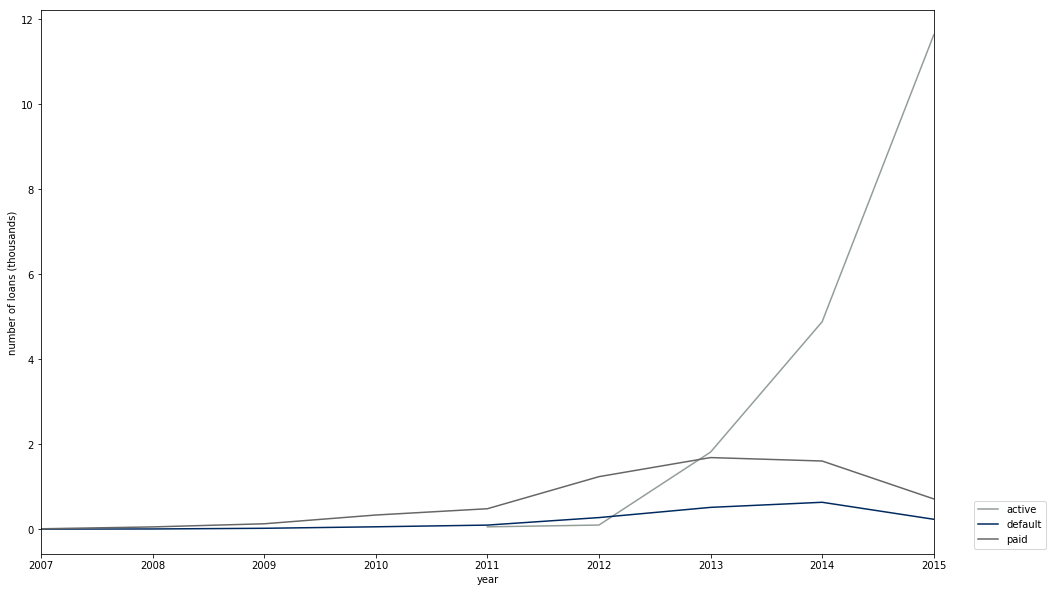

In [29]:
ax = default_pivot.unstack().plot(style='-',color=['#939D98','#002960','#666666'],figsize=(16,10))

scale_y = 1e3
ticks_y = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)

plt.xlabel('year')
plt.ylabel('number of loans (thousands)')
plt.legend(['active', 'default', 'paid'],bbox_to_anchor=(1.04,0), loc='lower left')
plt.savefig(os.path.join(figures_data_path, 'Fig8.png'), bbox_inches='tight')
plt.show()

    Changes in percantage of default, active and paid loans issued in different years

In [30]:
default_pivot = pd.pivot_table(data,values='id',index=['issue_year','loan_status_type'], aggfunc='count')
default_norm = pd.DataFrame(default_pivot.unstack().T.sum(), columns=['sum'])

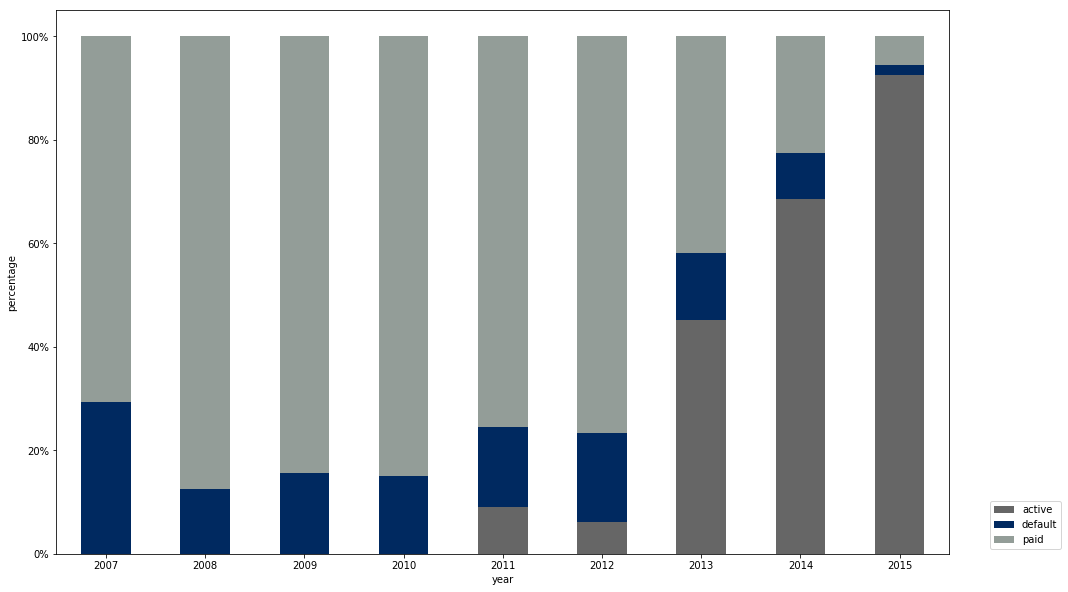

In [31]:
ax = default_pivot.unstack().divide(default_norm['sum'],axis=0).plot(kind='bar',stacked=True, figsize=(16,10), color=['#666666','#002960','#939D98'])
plt.xticks(rotation=0)
plt.xlabel('year')
plt.ylabel('percentage')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(['active', 'default', 'paid'],bbox_to_anchor=(1.04,0), loc='lower left')
plt.savefig(os.path.join(figures_data_path, 'Fig9.png'), bbox_inches='tight')
plt.show()

    Different purpose - different grade

In [32]:
grade_pivot = pd.pivot_table(data,values='id',index=['grade','purpose'], aggfunc='count')
grade_norm = pd.DataFrame(grade_pivot.unstack().T.sum(), columns=['sum'])

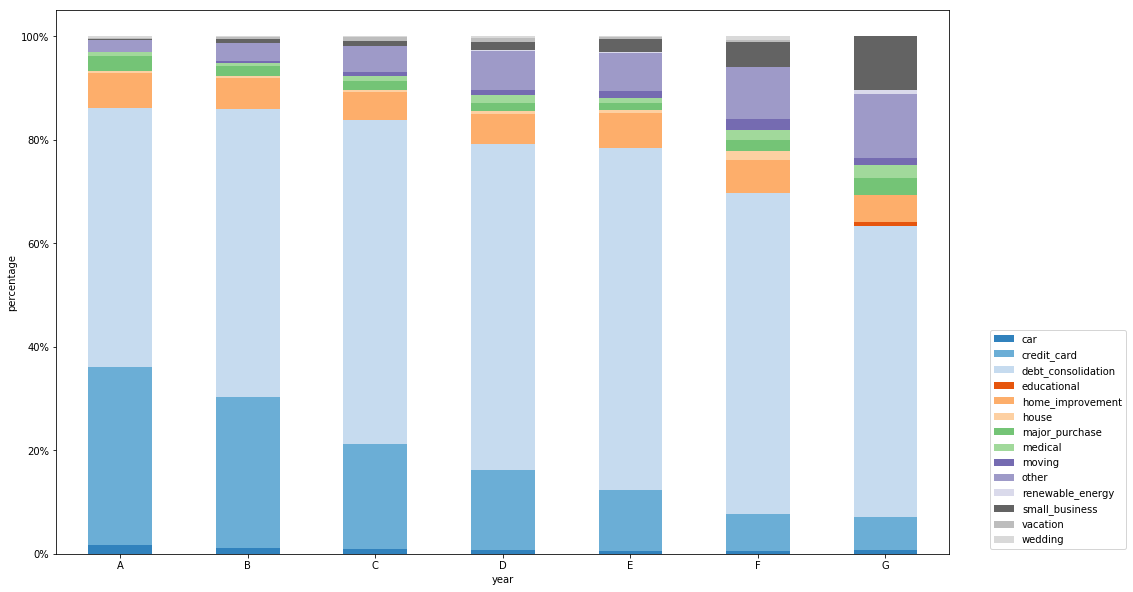

In [33]:
leg_leb=data['purpose'].value_counts().sort_index().index
ax = grade_pivot.unstack().divide(grade_norm['sum'],axis=0).plot(kind='bar',stacked=True,colormap='tab20c',figsize=(16,10))
plt.xlabel('year')
plt.xticks(rotation=0)
plt.ylabel('percentage')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(leg_leb,bbox_to_anchor=(1.04,0), loc='lower left')
plt.savefig(os.path.join(figures_data_path, 'Fig10.png'), bbox_inches='tight')
plt.show()

    Grade vs loan status type

In [34]:
grade_status_pivot = pd.pivot_table(data,values='id',index=['grade','loan_status_type'], aggfunc='count')
grade_status_norm = pd.DataFrame(grade_status_pivot.unstack().T.sum(), columns=['sum'])

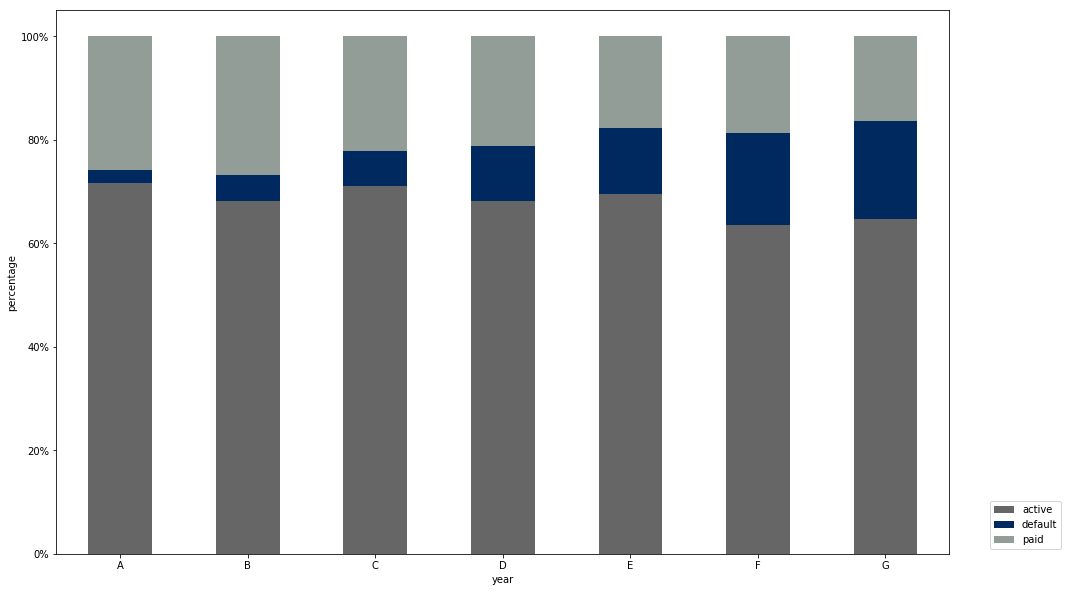

In [35]:
leg_leb=data['loan_status_type'].value_counts().sort_index().index
ax = grade_status_pivot.unstack().divide(grade_status_norm['sum'],axis=0).plot(kind='bar',stacked=True, color=['#666666','#002960','#939D98'],figsize=(16,10))
plt.xticks(rotation=0)
plt.xlabel('year')
plt.ylabel('percentage')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(leg_leb,bbox_to_anchor=(1.04,0), loc='lower left')
plt.savefig(os.path.join(figures_data_path, 'Fig11.png'), bbox_inches='tight')
plt.show()

    box plot the higher the grade (more risky loan) the higher the interest rates

C:\Users\michal.nawrot\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



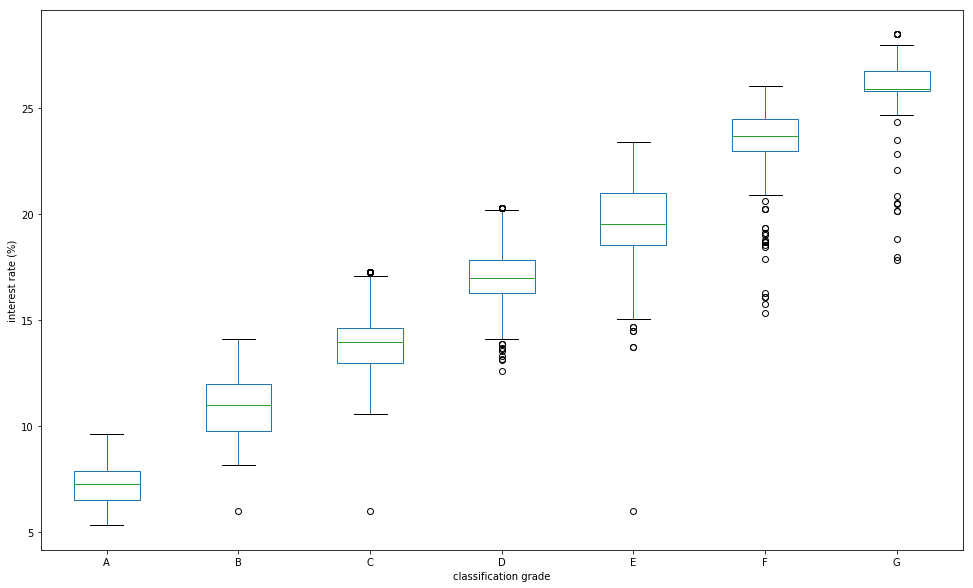

In [36]:
data.boxplot(column='int_rate',by='grade',figsize=(16,10),grid=False)
plt.xticks(rotation=0)
plt.xlabel('classification grade')
plt.ylabel('interest rate (%)')
plt.title("")
plt.suptitle("")
plt.savefig(os.path.join(figures_data_path, 'Fig12.png'), bbox_inches='tight')
plt.show()

    interest rate in time per loan term 
    Interest rate distribution by grade and by term

In [37]:
int_rate_table = pd.pivot_table(data,values='int_rate',index=['term','issue_year','grade'], aggfunc='mean').unstack()
int_rate_table_36 = int_rate_table.query('term == [" 36 months"]')
int_rate_table_60 = int_rate_table.query('term == [" 60 months"]')

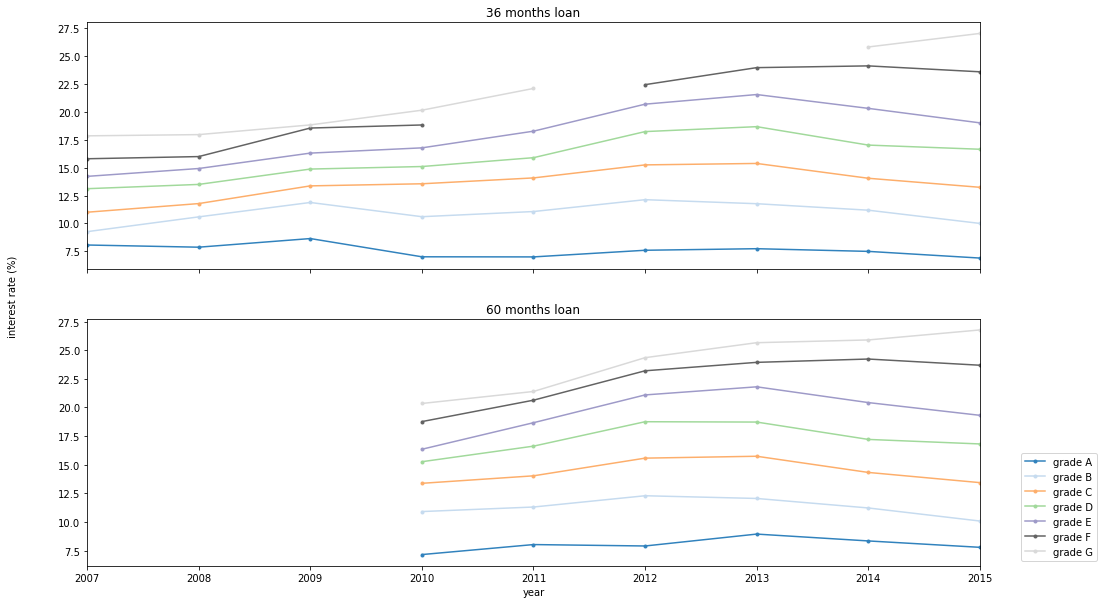

In [38]:
bars = (2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015)
y_pos_36 = (0, 1, 2, 3, 4, 5, 6, 7, 8)
y_pos_60 = (-3,-2,-1,0, 1, 2, 3, 4, 5)

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(16)
#fig.text(0.5, 0.04, 'interest rate (%)', ha='center', va='center')
fig.text(0.06, 0.5, 'interest rate (%)', ha='center', va='center', rotation='vertical')
int_rate_table_36.plot(style='.-', legend=False, ax=axes[0], title='36 months loan', colormap='tab20c',use_index=False)
int_rate_table_60.plot(style='.-', legend=False, ax=axes[1], title='60 months loan', colormap='tab20c',use_index=False)
plt.xticks(y_pos_60, bars)
plt.setp(axes[0].get_xticklabels(), visible=False)
plt.xlabel('year')
#plt.ylabel('interest rate (%)')
plt.legend(['grade A', 'grade B','grade C','grade D','grade E','grade F','grade G'],bbox_to_anchor=(1.04,0), loc='lower left')
plt.savefig(os.path.join(figures_data_path, 'Fig13.png'), bbox_inches='tight')
plt.show()